## DATA SCIENCE : PROJET DE SURVEILLENCE FERROVIAIRE POUR LA DETECTION DE SHUNT ET OPTIMISATION DE LA TENSION RESIDUELLE

#### Notebook réalisé par Mehdi BELAMINE - 13Avril2025

### Création d'un dataset sythétique

In [83]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts_param = 10  # Paramètre pour le nombre de shunts à générer
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts_param):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts_param - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs (MODIFIÉ)
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            # L'ID du shunt est attribué ici en fonction des séquences de 1
            # La logique de l'ID final sera gérée après la création du DataFrame

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame complet
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Attribution des ID de shunt basés sur les séquences de 1 (NOUVELLE LOGIQUE)
current_id = 0
in_shunt = False
for index, row in df_shunt_10juin.iterrows():
    if row['Shunt (0/1)'] == 1 and not in_shunt:
        current_id += 1
        in_shunt = True
        df_shunt_10juin.at[index, 'ID Shunt'] = current_id
    elif row['Shunt (0/1)'] == 1 and in_shunt:
        df_shunt_10juin.at[index, 'ID Shunt'] = current_id
    elif row['Shunt (0/1)'] == 0:
        in_shunt = False
        df_shunt_10juin.at[index, 'ID Shunt'] = 0 # Réinitialiser l'ID à 0 quand il n'y a pas de shunt

# Exporter les données où Shunt (0/1) est égal à 1 dans un fichier CSV nommé 'shunt_1.csv'
df_shunt_1 = df_shunt_10juin[df_shunt_10juin['Shunt (0/1)'] == 1].copy() # Utiliser .copy() pour éviter les warnings
df_shunt_1.to_csv('shunt_1.csv', index=False)

print("Les données avec Shunt (0/1) = 1 ont été exportées vers shunt_1.csv avec les ID de shunt.")

# (Le reste du code pour la transformée de Fourier et les graphiques peut rester si vous le souhaitez)

Les données avec Shunt (0/1) = 1 ont été exportées vers shunt_1.csv avec les ID de shunt.


### Répartition des classes Shunt (0/1)

Nombre de Shunt = 0: 204159
Nombre de Shunt = 1: 11841


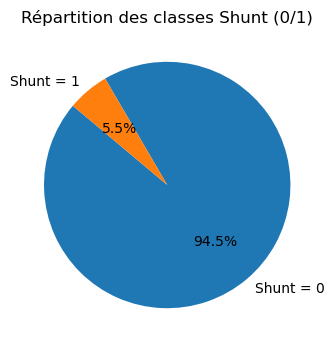

In [85]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts = 10
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = []
um71_v = []
ite_v = []
tr = []
shunt = []
date_heure = []
id_shunt = []

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s.append(i / frequence_echantillonnage_hz)
    date_heure.append(start_time + timedelta(seconds=i / frequence_echantillonnage_hz))

# Initialisation des valeurs de base
um71_base = np.full(nombre_total_echantillons, 0.06 + np.random.normal(0, ecart_type_bruit, nombre_total_echantillons))
ite_base = np.full(nombre_total_echantillons, 5.0 + np.random.normal(0, ecart_type_bruit, nombre_total_echantillons))
tr_base = np.random.normal(25.0, ecart_type_bruit * 2, nombre_total_echantillons)

# Initialisation des colonnes Shunt et ID Shunt
shunt_array = np.zeros(nombre_total_echantillons, dtype=int)
shunt_id_array = np.zeros(nombre_total_echantillons, dtype=int)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs
current_shunt_id = 1
for debut, fin in moments_shunt:
    shunt_array[debut:fin] = 1
    shunt_id_array[debut:fin] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
um71 = um71_base.copy()
ite = ite_base.copy()
tr = tr_base.copy()

for i in range(nombre_total_echantillons):
    if shunt_array[i] == 1:
        um71[i] = np.random.normal(0.001, 0.002)
        ite[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71,
    'ITE (V)': ite,
    'TR': tr,
    'Shunt (0/1)': shunt_array,
    'Date et Heure': date_heure,
    'ID Shunt': shunt_id_array
}

df_shunt_10juin = pd.DataFrame(data)

# Affichage du nombre de shunt=0 et shunt=1
shunt_counts = df_shunt_10juin['Shunt (0/1)'].value_counts()
print("Nombre de Shunt = 0:", shunt_counts[0])
print("Nombre de Shunt = 1:", shunt_counts[1])

# Création du graphique camembert
plt.figure(figsize=(4, 4))
plt.pie(shunt_counts, labels=['Shunt = 0', 'Shunt = 1'], autopct='%1.1f%%', startangle=140)
plt.title('Répartition des classes Shunt (0/1)')
plt.show()

### Visualisation de scourbes de tensions UM71 et ITE

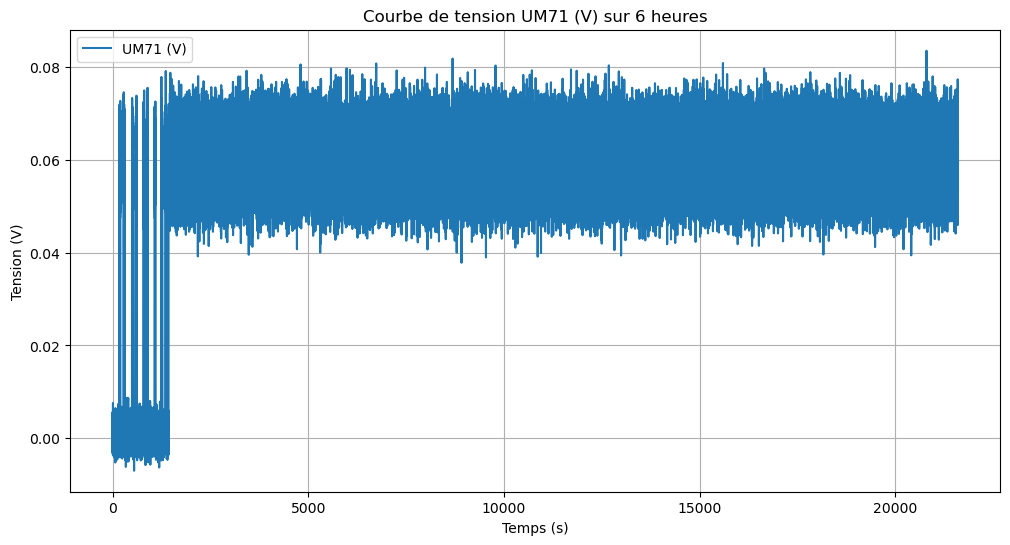

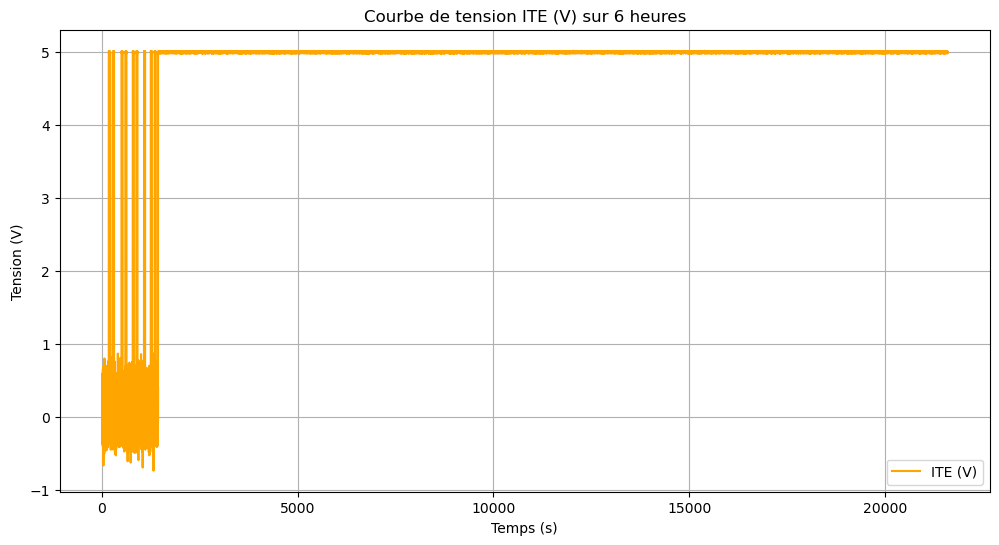

In [87]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts = 10
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = []
um71_v = []
ite_v = []
tr = []
shunt = []
date_heure = []
id_shunt = []

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s.append(i / frequence_echantillonnage_hz)
    date_heure.append(start_time + timedelta(seconds=i / frequence_echantillonnage_hz))

# Initialisation des valeurs de base
um71_base = np.full(nombre_total_echantillons, 0.06 + np.random.normal(0, ecart_type_bruit, nombre_total_echantillons))
ite_base = np.full(nombre_total_echantillons, 5.0 + np.random.normal(0, ecart_type_bruit, nombre_total_echantillons))
tr_base = np.random.normal(25.0, ecart_type_bruit * 2, nombre_total_echantillons)

# Initialisation des colonnes Shunt et ID Shunt
shunt_array = np.zeros(nombre_total_echantillons, dtype=int)
shunt_id_array = np.zeros(nombre_total_echantillons, dtype=int)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs
current_shunt_id = 1
for debut, fin in moments_shunt:
    shunt_array[debut:fin] = 1
    shunt_id_array[debut:fin] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
um71 = um71_base.copy()
ite = ite_base.copy()
tr = tr_base.copy()

for i in range(nombre_total_echantillons):
    if shunt_array[i] == 1:
        um71[i] = np.random.normal(0.001, 0.002)
        ite[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71,
    'ITE (V)': ite,
    'TR': tr,
    'Shunt (0/1)': shunt_array,
    'Date et Heure': date_heure,
    'ID Shunt': shunt_id_array
}

df_shunt_10juin = pd.DataFrame(data)

# Création des courbes de tension pour UM71
plt.figure(figsize=(12, 6))
plt.plot(df_shunt_10juin['Temps (s)'], df_shunt_10juin['UM71 (V)'], label='UM71 (V)')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.title('Courbe de tension UM71 (V) sur 6 heures')
plt.grid(True)
plt.legend()
plt.show()

# Création des courbes de tension pour ITE
plt.figure(figsize=(12, 6))
plt.plot(df_shunt_10juin['Temps (s)'], df_shunt_10juin['ITE (V)'], label='ITE (V)', color='orange')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.title('Courbe de tension ITE (V) sur 6 heures')
plt.grid(True)
plt.legend()
plt.show()

### Visualisation de la combinaison des 2 courbes de tensions

Longueur de temps_s: 216000
Longueur de um71_v: 216000
Longueur de ite_v: 216000
Longueur de tr: 216000
Longueur de shunt: 216000
Longueur de date_heure: 216000
Longueur de id_shunt: 216000
Nombre total d'échantillons attendu: 216000


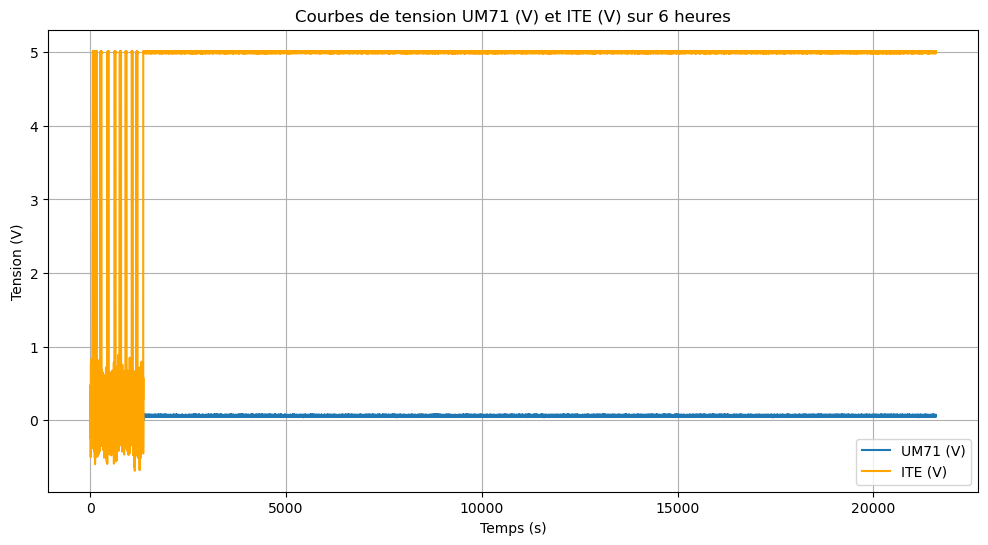

In [89]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts = 10
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Vérification des longueurs des listes (redondant mais pour la clarté)
print("Longueur de temps_s:", len(temps_s))
print("Longueur de um71_v:", len(um71_v))
print("Longueur de ite_v:", len(ite_v))
print("Longueur de tr:", len(tr))
print("Longueur de shunt:", len(shunt))
print("Longueur de date_heure:", len(date_heure))
print("Longueur de id_shunt:", len(id_shunt))
print("Nombre total d'échantillons attendu:", nombre_total_echantillons)

# Création du DataFrame
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Création des courbes de tension combinées
plt.figure(figsize=(12, 6))
plt.plot(df_shunt_10juin['Temps (s)'], df_shunt_10juin['UM71 (V)'], label='UM71 (V)')
plt.plot(df_shunt_10juin['Temps (s)'], df_shunt_10juin['ITE (V)'], label='ITE (V)', color='orange')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.title('Courbes de tension UM71 (V) et ITE (V) sur 6 heures')
plt.grid(True)
plt.legend()
plt.show()

### Exporter les shunt=1 dans shunt_1.csv

In [97]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts_param = 10  # Paramètre pour le nombre de shunts à générer
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts_param):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts_param - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs (MODIFIÉ)
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame complet
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Exporter les données où Shunt (0/1) est égal à 1 dans un fichier CSV nommé 'shunt_1.csv'
df_shunt_1 = df_shunt_10juin[df_shunt_10juin['Shunt (0/1)'] == 1].copy()
df_shunt_1.to_csv('shunt_1.csv', index=False)

print("Les données avec Shunt (0/1) = 1 ont été exportées vers shunt_1.csv avec les ID de shunt.")

# (Le reste du code pour la transformée de Fourier et les graphiques peut rester si vous le souhaitez)

Les données avec Shunt (0/1) = 1 ont été exportées vers shunt_1.csv avec les ID de shunt.


In [98]:
df_shunt_1

,Temps (s),UM71 (V),ITE (V),TR,Shunt (0/1),Date et Heure,ID Shunt
0,0.0,0.004027,0.026146,25.012004,1,2025-06-10 09:00:00.000,1
1,0.1,-0.000670,0.209047,24.984215,1,2025-06-10 09:00:00.100,1
2,0.2,0.001173,0.324458,25.007779,1,2025-06-10 09:00:00.200,1
3,0.3,-0.000912,0.199443,25.024554,1,2025-06-10 09:00:00.300,1
4,0.4,0.002294,-0.138533,25.005807,1,2025-06-10 09:00:00.400,1
...,...,...,...,...,...,...,...
15197,1519.7,-0.000985,0.603748,24.994199,1,2025-06-10 09:25:19.700,10
15198,1519.8,0.000049,0.531529,24.992574,1,2025-06-10 09:25:19.800,10
15199,1519.9,0.001201,-0.172260,25.004364,1,2025-06-10 09:25:19.900,10
15200,1520.0,0.004780,-0.150701,24.988048,1,2025-06-10 09:25:20.000,10


### EDA

In [116]:
df_shunt_1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12502 entries, 0 to 15201
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Temps (s)      12502 non-null  float64       
 1   UM71 (V)       12502 non-null  float64       
 2   ITE (V)        12502 non-null  float64       
 3   TR             12502 non-null  float64       
 4   Shunt (0/1)    12502 non-null  int64         
 5   Date et Heure  12502 non-null  datetime64[ns]
 6   ID Shunt       12502 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 781.4 KB


In [122]:
df_shunt_1['TR'].describe()

count    12502.000000
mean        24.999984
std          0.010041
min         24.963758
25%         24.993229
50%         25.000005
75%         25.006775
max         25.042497
Name: TR, dtype: float64

### DISTRIBUTION DES VARIABLES QUANTITATIVES

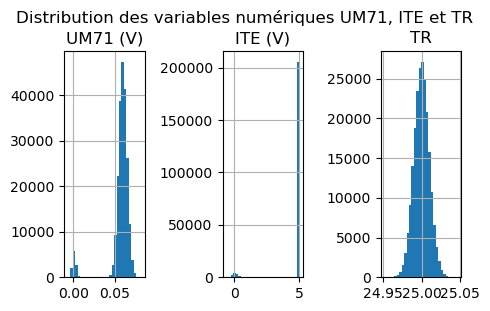

In [137]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts_param = 10  # Paramètre pour le nombre de shunts à générer
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts_param):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts_param - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs (MODIFIÉ)
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame complet
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Visualisation de la distribution des variables numériques UM71, ITE et TR
numerical_cols = ['UM71 (V)', 'ITE (V)', 'TR']
df_shunt_10juin[numerical_cols].hist(bins=30, figsize=(5, 3), layout=(1, 3))
plt.tight_layout()
plt.suptitle('Distribution des variables numériques UM71, ITE et TR', y=1.02)
plt.show()

# (Le reste du code pour la transformée de Fourier et l'exportation CSV peut rester si vous le souhaitez)

### MATRICE DE CORRELATION

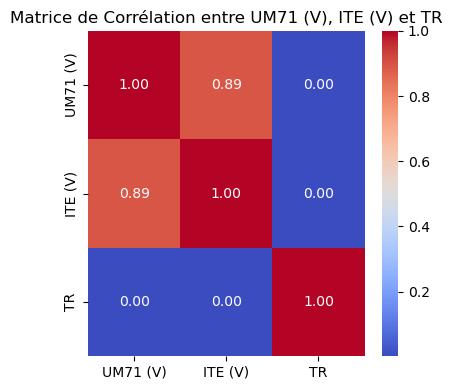

In [142]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns  # Importez la librairie seaborn pour une meilleure visualisation

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts_param = 10  # Paramètre pour le nombre de shunts à générer
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts_param):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts_param - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs (MODIFIÉ)
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame complet
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Calcul de la matrice de corrélation
correlation_matrix = df_shunt_10juin[['UM71 (V)', 'ITE (V)', 'TR']].corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation entre UM71 (V), ITE (V) et TR')
plt.tight_layout()
plt.show()

### TRANSFORMEE DE FOURIER : DOMAINE TEMPOREL VERS DOMAINE FREQUENTIEL

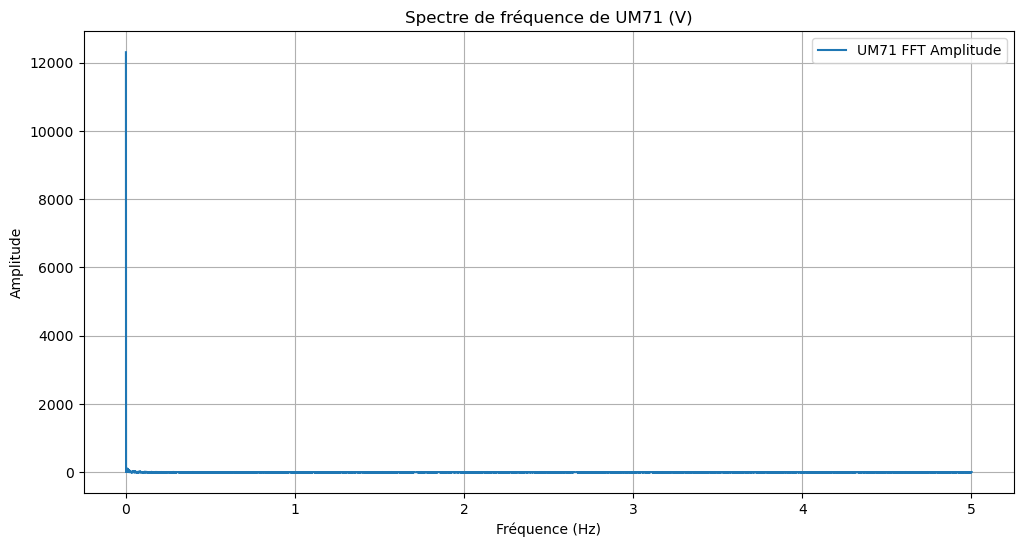

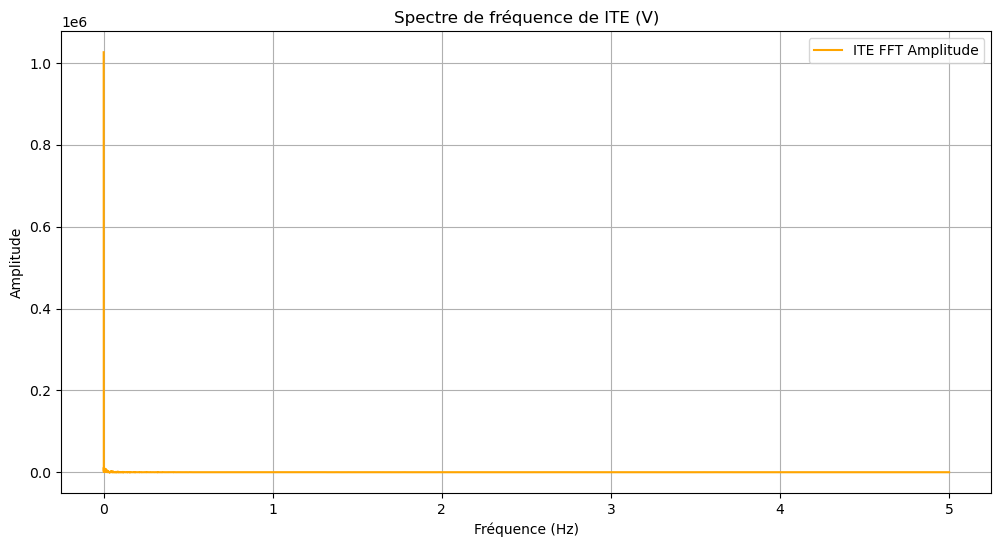

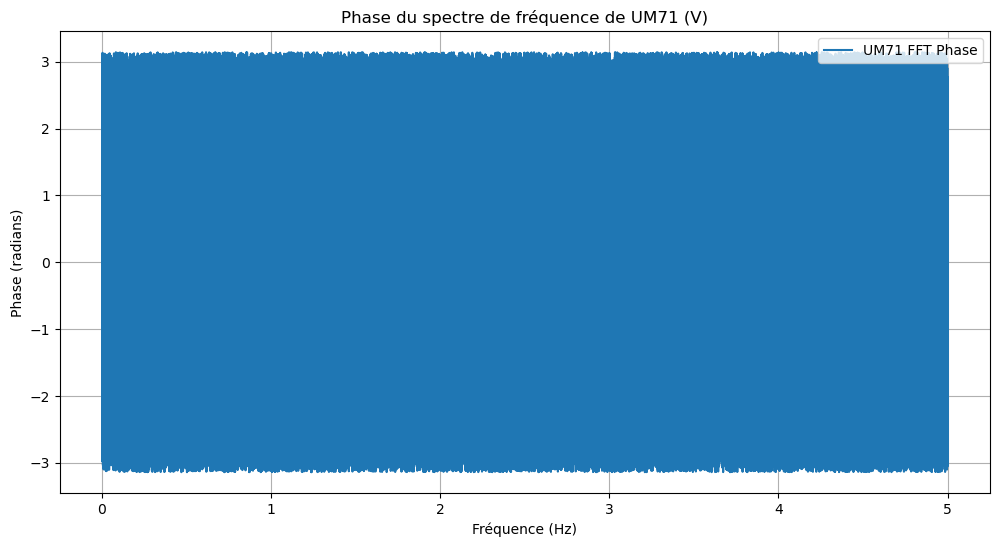

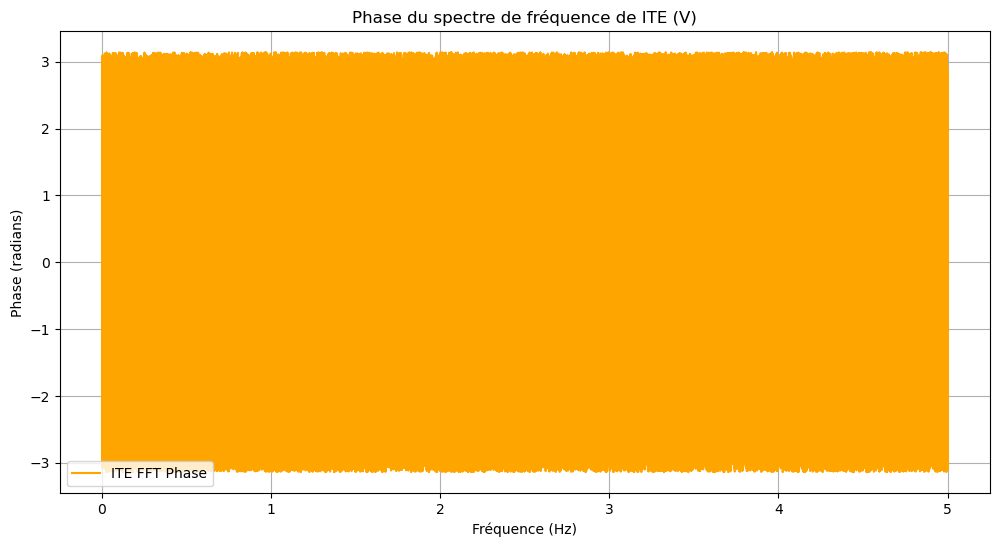

In [105]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts = 10
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Appliquer la Transformée de Fourier à UM71 et ITE
um71_fft = fft(df_shunt_10juin['UM71 (V)'].values)
ite_fft = fft(df_shunt_10juin['ITE (V)'].values)

# Calculer les fréquences correspondantes
frequencies = fftfreq(nombre_total_echantillons, 1 / frequence_echantillonnage_hz)

# Afficher le spectre de fréquence (amplitude)
plt.figure(figsize=(12, 6))
plt.plot(frequencies[frequencies >= 0], np.abs(um71_fft)[frequencies >= 0], label='UM71 FFT Amplitude')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectre de fréquence de UM71 (V)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(frequencies[frequencies >= 0], np.abs(ite_fft)[frequencies >= 0], label='ITE FFT Amplitude', color='orange')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.title('Spectre de fréquence de ITE (V)')
plt.grid(True)
plt.legend()
plt.show()

# Afficher le spectre de fréquence (phase)
plt.figure(figsize=(12, 6))
plt.plot(frequencies[frequencies >= 0], np.angle(um71_fft)[frequencies >= 0], label='UM71 FFT Phase')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Phase (radians)')
plt.title('Phase du spectre de fréquence de UM71 (V)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(frequencies[frequencies >= 0], np.angle(ite_fft)[frequencies >= 0], label='ITE FFT Phase', color='orange')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Phase (radians)')
plt.title('Phase du spectre de fréquence de ITE (V)')
plt.grid(True)
plt.legend()
plt.show()

### Spectogramme

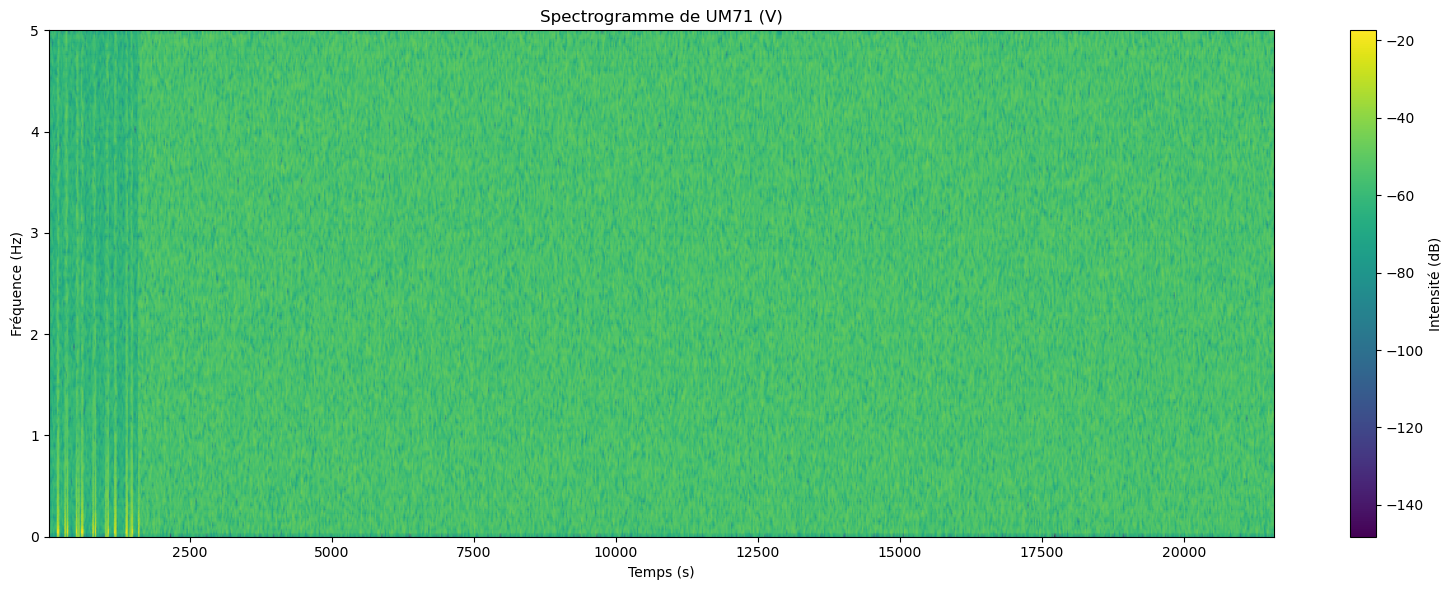

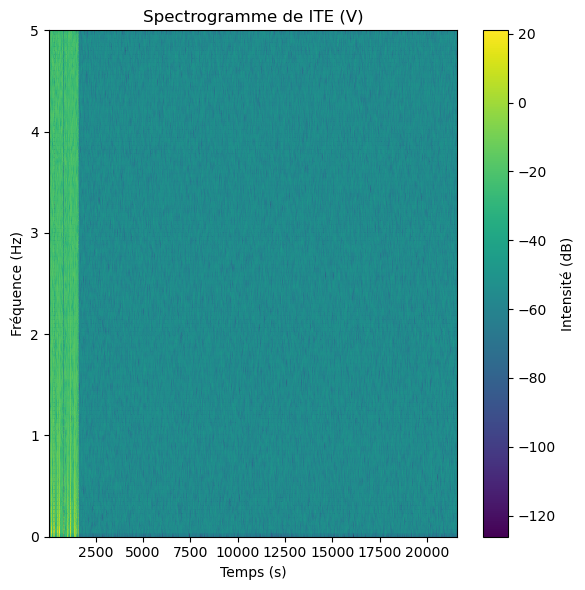

In [112]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram

# Paramètres
date_cible = datetime(2025, 6, 10, 12, 0, 0)
duree_heures_fenetre = 6
frequence_echantillonnage_hz = 10
nombre_total_echantillons = duree_heures_fenetre * 3600 * frequence_echantillonnage_hz
nombre_shunts = 10
duree_min_shunt_secondes = 30
duree_max_shunt_secondes = 200
ecart_type_bruit = 0.005
espacement_min_secondes = 30

# Initialisation des listes
temps_s = [None] * nombre_total_echantillons
um71_v = [None] * nombre_total_echantillons
ite_v = [None] * nombre_total_echantillons
tr = [None] * nombre_total_echantillons
shunt = [0] * nombre_total_echantillons
date_heure = [None] * nombre_total_echantillons
id_shunt = [0] * nombre_total_echantillons

# Génération de la base temporelle autour de la date cible
start_time = date_cible - timedelta(hours=duree_heures_fenetre / 2)
for i in range(nombre_total_echantillons):
    temps_s[i] = i / frequence_echantillonnage_hz
    date_heure[i] = start_time + timedelta(seconds=i / frequence_echantillonnage_hz)
    um71_v[i] = 0.06 + np.random.normal(0, ecart_type_bruit)
    ite_v[i] = 5.0 + np.random.normal(0, ecart_type_bruit)
    tr[i] = np.random.normal(25.0, ecart_type_bruit * 2)

# Sélection aléatoire des moments de début et durée des shunts
moments_shunt = []
dernier_fin_shunt = -int(espacement_min_secondes * frequence_echantillonnage_hz)

for i in range(nombre_shunts):
    duree_min_echantillons = int(duree_min_shunt_secondes * frequence_echantillonnage_hz)
    duree_max_echantillons = int(duree_max_shunt_secondes * frequence_echantillonnage_hz)

    # Calcul de la durée maximale autorisée pour ce shunt pour pouvoir placer les suivants
    temps_restant_echantillons = nombre_total_echantillons - (dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz))
    duree_max_autorisee = temps_restant_echantillons - (nombre_shunts - 1 - i) * (duree_min_echantillons + int(espacement_min_secondes * frequence_echantillonnage_hz))

    if duree_max_autorisee < duree_min_echantillons:
        raise ValueError(f"Impossible de placer le shunt {i+1} avec les contraintes données.")

    duree_effective_shunt = random.randint(duree_min_echantillons, int(min(duree_max_echantillons, duree_max_autorisee)))

    debut_shunt = dernier_fin_shunt + int(espacement_min_secondes * frequence_echantillonnage_hz)
    fin_shunt = debut_shunt + duree_effective_shunt
    moments_shunt.append((debut_shunt, fin_shunt))
    dernier_fin_shunt = fin_shunt

moments_shunt.sort(key=lambda x: x[0])

# Activation des shunts et assignation des IDs
current_shunt_id = 1
for debut, fin in moments_shunt:
    for j in range(debut, fin):
        if 0 <= j < nombre_total_echantillons:
            shunt[j] = 1
            id_shunt[j] = current_shunt_id
    current_shunt_id += 1

# Application des "shunts" aux valeurs
for i in range(nombre_total_echantillons):
    if shunt[i] == 1:
        um71_v[i] = np.random.normal(0.001, 0.002)
        ite_v[i] = np.random.normal(0.1, 0.2)

# Création du DataFrame
data = {
    'Temps (s)': temps_s,
    'UM71 (V)': um71_v,
    'ITE (V)': ite_v,
    'TR': tr,
    'Shunt (0/1)': shunt,
    'Date et Heure': date_heure,
    'ID Shunt': id_shunt
}

df_shunt_10juin = pd.DataFrame(data)

# Calcul du spectrogramme pour UM71
freqs_um71, times_um71, Sxx_um71 = spectrogram(df_shunt_10juin['UM71 (V)'].values, fs=frequence_echantillonnage_hz)

# Calcul du spectrogramme pour ITE
freqs_ite, times_ite, Sxx_ite = spectrogram(df_shunt_10juin['ITE (V)'].values, fs=frequence_echantillonnage_hz)

# Affichage du spectrogramme pour UM71
plt.figure(figsize=(16, 6))
plt.pcolormesh(times_um71, freqs_um71, 10 * np.log10(Sxx_um71), shading='gouraud')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.title('Spectrogramme de UM71 (V)')
plt.colorbar(label='Intensité (dB)')
plt.tight_layout()
plt.show()

# Affichage du spectrogramme pour ITE
plt.figure(figsize=(6, 6))
plt.pcolormesh(times_ite, freqs_ite, 10 * np.log10(Sxx_ite), shading='gouraud')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.title('Spectrogramme de ITE (V)')
plt.colorbar(label='Intensité (dB)')
plt.tight_layout()
plt.show()

In [ ]:
_________________________________________________________________________________________________________________

### Création d'un dataset synthétique de 10trains pour 6 heures

1000 trains répartis sur 10 jours.

Chaque train a un début et une fin de shunt générés aléatoirement (durée raisonnable).

Les courbes de tension UM71 et ITE respectent les seuils normatifs.

30% des shunts ont une TR injectée aléatoirement après le shunt.

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta

# ----------------------------
# Paramètres
# ----------------------------
np.random.seed(42)

nombre_trains = 10
duree_journee_sec = 60*60*6         #24 * 60 * 60  # 1 jour = 86400 secondes
frequence = 1  # 1 point par seconde
temps_total = np.arange(0, duree_journee_sec, frequence)

valeur_normale_um71 = 0.06
valeur_normale_ite = 5.0

def val_shunt_um71(): return np.random.uniform(0.001, 0.02)
def val_shunt_ite(): return np.random.uniform(0.1, 1.0)

um71 = np.full_like(temps_total, valeur_normale_um71, dtype=float)
ite = np.full_like(temps_total, valeur_normale_ite, dtype=float)
tr = np.zeros_like(temps_total, dtype=int)  # Initialisation de la colonne TR
shunt = np.zeros_like(temps_total, dtype=int)

# ----------------------------
# Génération des shunts sans chevauchement
# ----------------------------
shunt_durees = np.random.randint(30, 201, nombre_trains)
shunt_debuts = []

temps_occupe = []

for duree in shunt_durees:
    while True:
        debut = np.random.randint(0, duree_journee_sec - duree)
        fin = debut + duree
        # Vérifier qu'il n'y a pas de conflit avec un shunt déjà placé
        conflit = any([debut <= f and fin >= d for (d, f) in temps_occupe])
        if not conflit:
            shunt_debuts.append(debut)
            temps_occupe.append((debut, fin))
            break

# ----------------------------
# Appliquer les shunts et générer TR
# ----------------------------
for debut, duree in zip(shunt_debuts, shunt_durees):
    fin = debut + duree
    mask = (temps_total >= debut) & (temps_total <= fin)
    shunt[mask] = 1
    um71[mask] = [val_shunt_um71() for _ in range(mask.sum())]
    ite[mask] = [val_shunt_ite() for _ in range(mask.sum())]

    # Simuler une anomalie (TR) pendant le shunt
    if np.random.rand() < 0.1:  # 10% de chances d'avoir une anomalie pendant le shunt
        tr[mask] = np.random.choice([1, 0], size=np.sum(mask), p=[0.2, 0.8])  # 20% de chance d'avoir un TR durant un shunt

# ----------------------------
# Création du DataFrame
# ----------------------------
df = pd.DataFrame({
    "Temps (s)": temps_total,
    "UM71 (V)": np.round(um71, 5),
    "ITE (V)": np.round(ite, 5),
    "TR": tr,
    "Shunt (0/1)": shunt
})

df["Date et Heure"] = df["Temps (s)"].apply(lambda x: timedelta(seconds=int(x)))
#Ajout de la colonne TR : La colonne TR contient des valeurs
#aléatoires simulant des anomalies de tension résiduelle
#pendant un shunt (avec 20% de chance de générer une anomalie, et 80% de chance qu'il n'y ait pas de TR pendant le shunt).

# ----------------------------
# Identifier les périodes de shunt et ajouter l'ID Shunt
# ----------------------------
shunt_periods = []
in_shunt = False
shunt_id = 0

for i in range(len(df)):
    if df.loc[i, 'Shunt (0/1)'] == 1 and not in_shunt:
        start_idx = i
        in_shunt = True
        shunt_id += 1  # Nouveau shunt
    elif df.loc[i, 'Shunt (0/1)'] == 0 and in_shunt:
        end_idx = i - 1
        duree = end_idx - start_idx + 1
        shunt_periods.append({
            'Début (s)': df.loc[start_idx, 'Temps (s)'],
            'Fin (s)': df.loc[end_idx, 'Temps (s)'],
            'Durée (s)': duree,
            'Heure Début': df.loc[start_idx, 'Date et Heure'],
            'Heure Fin': df.loc[end_idx, 'Date et Heure'],
            'ID Shunt': shunt_id  # Ajouter l'ID du shunt
        })
        in_shunt = False

# Cas où le dernier point est encore en shunt
if in_shunt:
    end_idx = len(df) - 1
    duree = end_idx - start_idx + 1
    shunt_periods.append({
        'Début (s)': df.loc[start_idx, 'Temps (s)'],
        'Fin (s)': df.loc[end_idx, 'Temps (s)'],
        'Durée (s)': duree,
        'Heure Début': df.loc[start_idx, 'Date et Heure'],
        'Heure Fin': df.loc[end_idx, 'Date et Heure'],
        'ID Shunt': shunt_id
    })

df_shunts = pd.DataFrame(shunt_periods)

# Ajouter les ID Shunt dans le DataFrame principal
df['ID Shunt'] = 0
for shunt_period in shunt_periods:
    mask = (df['Temps (s)'] >= shunt_period['Début (s)']) & (df['Temps (s)'] <= shunt_period['Fin (s)'])
    df.loc[mask, 'ID Shunt'] = shunt_period['ID Shunt']

# ----------------------------
# Export
# ----------------------------
df.to_csv("dataset_synthetique_shunt_avec_tr_tf.csv", index=False)
df_shunts.to_csv("periode_shunts_avec_id_tf.csv", index=False)

print("✅ Dataset avec TR généré.")
print(df.head(20))


✅ Dataset avec TR généré.
    Temps (s)  UM71 (V)  ITE (V)  TR  Shunt (0/1)   Date et Heure  ID Shunt
0           0      0.06      5.0   0            0 0 days 00:00:00         0
1           1      0.06      5.0   0            0 0 days 00:00:01         0
2           2      0.06      5.0   0            0 0 days 00:00:02         0
3           3      0.06      5.0   0            0 0 days 00:00:03         0
4           4      0.06      5.0   0            0 0 days 00:00:04         0
5           5      0.06      5.0   0            0 0 days 00:00:05         0
6           6      0.06      5.0   0            0 0 days 00:00:06         0
7           7      0.06      5.0   0            0 0 days 00:00:07         0
8           8      0.06      5.0   0            0 0 days 00:00:08         0
9           9      0.06      5.0   0            0 0 days 00:00:09         0
10         10      0.06      5.0   0            0 0 days 00:00:10         0
11         11      0.06      5.0   0            0 0 days 00:00

In [3]:
import pandas as pd

df = pd.read_csv("dataset_synthetique_shunt_avec_tr_tf.csv")
df.head(100)


,Temps (s),UM71 (V),ITE (V),TR,Shunt (0/1),Date et Heure,ID Shunt
0,0,0.06,5.0,0,0,0 days 00:00:00,0
1,1,0.06,5.0,0,0,0 days 00:00:01,0
2,2,0.06,5.0,0,0,0 days 00:00:02,0
3,3,0.06,5.0,0,0,0 days 00:00:03,0
4,4,0.06,5.0,0,0,0 days 00:00:04,0
...,...,...,...,...,...,...,...
95,95,0.06,5.0,0,0,0 days 00:01:35,0
96,96,0.06,5.0,0,0,0 days 00:01:36,0
97,97,0.06,5.0,0,0,0 days 00:01:37,0
98,98,0.06,5.0,0,0,0 days 00:01:38,0


In [5]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("dataset_synthetique_shunt_avec_tr_tf.csv")

# Liste pour stocker les durées
durees_shunt = []
en_shunt = False
duree_courante = 0

for val in df['Shunt (0/1)']:
    if val == 1:
        if not en_shunt:
            en_shunt = True
            duree_courante = 1
        else:
            duree_courante += 1
    else:
        if en_shunt:
            durees_shunt.append(duree_courante)
            en_shunt = False

# S'assurer de capter le dernier shunt si le dataset finit avec un shunt
if en_shunt:
    durees_shunt.append(duree_courante)

# Affichage des résultats
print(f"📌 Nombre total de shunts détectés : {len(durees_shunt)}")
print("📊 Durée de chaque shunt (en secondes) :")
for i, d in enumerate(durees_shunt, 1):
    print(f"  Shunt {i}: {d} secondes")


📌 Nombre total de shunts détectés : 10
📊 Durée de chaque shunt (en secondes) :
  Shunt 1: 102 secondes
  Shunt 2: 137 secondes
  Shunt 3: 51 secondes
  Shunt 4: 152 secondes
  Shunt 5: 133 secondes
  Shunt 6: 105 secondes
  Shunt 7: 45 secondes
  Shunt 8: 133 secondes
  Shunt 9: 123 secondes
  Shunt 10: 118 secondes


In [7]:
import numpy as np
import pandas as pd
from datetime import timedelta

# ----------------------------
# Paramètres
# ----------------------------
np.random.seed(42)

nombre_trains = 10
duree_journee_sec = 60*60*6       #24 * 60 * 60  # 1 jour = 86400 secondes
frequence = 1  # 1 point par seconde
temps_total = np.arange(0, duree_journee_sec, frequence)

valeur_normale_um71 = 0.06
valeur_normale_ite = 5.0

def val_shunt_um71(): return np.random.uniform(0.001, 0.02)
def val_shunt_ite(): return np.random.uniform(0.1, 1.0)

um71 = np.full_like(temps_total, valeur_normale_um71, dtype=float)
ite = np.full_like(temps_total, valeur_normale_ite, dtype=float)
tr = np.zeros_like(temps_total, dtype=int)
shunt = np.zeros_like(temps_total, dtype=int)

# ----------------------------
# Génération des shunts sans chevauchement
# ----------------------------
shunt_durees = np.random.randint(30, 201, nombre_trains)
shunt_debuts = []

temps_occupe = []

for duree in shunt_durees:
    while True:
        debut = np.random.randint(0, duree_journee_sec - duree)
        fin = debut + duree
        # Vérifier qu'il n'y a pas de conflit avec un shunt déjà placé
        conflit = any([debut <= f and fin >= d for (d, f) in temps_occupe])
        if not conflit:
            shunt_debuts.append(debut)
            temps_occupe.append((debut, fin))
            break

# ----------------------------
# Appliquer les shunts
# ----------------------------
for debut, duree in zip(shunt_debuts, shunt_durees):
    fin = debut + duree
    mask = (temps_total >= debut) & (temps_total <= fin)
    shunt[mask] = 1
    um71[mask] = [val_shunt_um71() for _ in range(mask.sum())]
    ite[mask] = [val_shunt_ite() for _ in range(mask.sum())]

    # Simuler une anomalie (TR) pendant le shunt
    tr[mask] = np.random.choice([0, 1], size=np.sum(mask), p=[0.8, 0.2])  # 20% de chance d'avoir une anomalie pendant le shunt

# ----------------------------
# Création du DataFrame
# ----------------------------
df = pd.DataFrame({
    "Temps (s)": temps_total,
    "UM71 (V)": np.round(um71, 5),
    "ITE (V)": np.round(ite, 5),
    "TR": tr,
    "Shunt (0/1)": shunt
})

df["Date et Heure"] = df["Temps (s)"].apply(lambda x: timedelta(seconds=int(x)))

# ----------------------------
# Identifier les périodes de shunt
# ----------------------------
shunt_periods = []
in_shunt = False

for i in range(len(df)):
    if df.loc[i, 'Shunt (0/1)'] == 1 and not in_shunt:
        start_idx = i
        in_shunt = True
    elif df.loc[i, 'Shunt (0/1)'] == 0 and in_shunt:
        end_idx = i - 1
        duree = end_idx - start_idx + 1
        shunt_periods.append({
            'Début (s)': df.loc[start_idx, 'Temps (s)'],
            'Fin (s)': df.loc[end_idx, 'Temps (s)'],
            'Durée (s)': duree,
            'Heure Début': df.loc[start_idx, 'Date et Heure'],
            'Heure Fin': df.loc[end_idx, 'Date et Heure']
        })
        in_shunt = False

# Cas où le dernier point est encore en shunt
if in_shunt:
    end_idx = len(df) - 1
    duree = end_idx - start_idx + 1
    shunt_periods.append({
        'Début (s)': df.loc[start_idx, 'Temps (s)'],
        'Fin (s)': df.loc[end_idx, 'Temps (s)'],
        'Durée (s)': duree,
        'Heure Début': df.loc[start_idx, 'Date et Heure'],
        'Heure Fin': df.loc[end_idx, 'Date et Heure']
    })

df_shunts = pd.DataFrame(shunt_periods)

# ----------------------------
# Export
# ----------------------------
df.to_csv("dataset_synthetique_shunt_corrige_tf.csv", index=False)
df_shunts.to_csv("periode_shunts_tf.csv", index=False)

print("✅ Dataset avec shunts non superposés généré.")
print(df_shunts)


✅ Dataset avec shunts non superposés généré.
   Début (s)  Fin (s)  Durée (s)     Heure Début       Heure Fin
0        769      870        102 0 days 00:12:49 0 days 00:14:30
1       1685     1821        137 0 days 00:28:05 0 days 00:30:21
2       2433     2483         51 0 days 00:40:33 0 days 00:41:23
3       5051     5202        152 0 days 01:24:11 0 days 01:26:42
4       5311     5443        133 0 days 01:28:31 0 days 01:30:43
5       6420     6524        105 0 days 01:47:00 0 days 01:48:44
6       8322     8366         45 0 days 02:18:42 0 days 02:19:26
7      11363    11495        133 0 days 03:09:23 0 days 03:11:35
8      16023    16145        123 0 days 04:27:03 0 days 04:29:05
9      17568    17685        118 0 days 04:52:48 0 days 04:54:45


### POUR 50 TRAINS DONC 50 SHUNT en 6H

In [9]:
import numpy as np
import pandas as pd
from datetime import timedelta

# ----------------------------
# Paramètres
# ----------------------------
np.random.seed(42)

nombre_trains = 50  # Nombre de shunts
duree_journee_sec = 6 * 60 * 60  # 1 jour = 86400 secondes
frequence = 1  # 1 point par seconde
temps_total = np.arange(0, duree_journee_sec, frequence)

valeur_normale_um71 = 0.06
valeur_normale_ite = 5.0

def val_shunt_um71(): return np.random.uniform(0.001, 0.02)
def val_shunt_ite(): return np.random.uniform(0.1, 1.0)

um71 = np.full_like(temps_total, valeur_normale_um71, dtype=float)
ite = np.full_like(temps_total, valeur_normale_ite, dtype=float)
tr = np.zeros_like(temps_total, dtype=int)
shunt = np.zeros_like(temps_total, dtype=int)

# ----------------------------
# Génération des shunts sans chevauchement (sans espacement minimum)
# ----------------------------
shunt_durees = np.random.randint(30, 201, nombre_trains)
shunt_debuts = []
temps_occupe = []

for duree in shunt_durees:
    while True:
        debut = np.random.randint(0, duree_journee_sec - duree)
        fin = debut + duree
        # Vérifier qu'il n'y a pas de conflit avec un shunt déjà placé
        conflit = any([debut <= f and fin >= d for (d, f) in temps_occupe])
        if not conflit:
            shunt_debuts.append(debut)
            temps_occupe.append((debut, fin))
            break

# Trier les shunts par leur début pour la cohérence
shunt_debuts.sort()
temps_occupe.sort()

# ----------------------------
# Appliquer les shunts
# ----------------------------
for debut, duree in zip(shunt_debuts, shunt_durees):
    fin = debut + duree
    mask = (temps_total >= debut) & (temps_total <= fin)
    shunt[mask] = 1
    um71[mask] = [val_shunt_um71() for _ in range(mask.sum())]
    ite[mask] = [val_shunt_ite() for _ in range(mask.sum())]

# ----------------------------
# Génération aléatoire et espacée des valeurs de TR
# ----------------------------
nombre_tr = np.random.randint(10, 30)  # Nombre aléatoire de valeurs TR à insérer
tr_indices = np.random.choice(np.arange(0, duree_journee_sec, 60 * 5), size=nombre_tr, replace=False) # Indices espacés d'au moins 5 minutes
tr_valeurs = np.random.randint(1, 16, size=nombre_tr)

for index, valeur in zip(tr_indices, tr_valeurs):
    if index < len(tr):
        tr[index] = valeur

# ----------------------------
# Création du DataFrame
# ----------------------------
df = pd.DataFrame({
    "Temps (s)": temps_total,
    "UM71 (V)": np.round(um71, 5),
    "ITE (V)": np.round(ite, 5),
    "TR": tr,
    "Shunt (0/1)": shunt
})

df["Date et Heure"] = df["Temps (s)"].apply(lambda x: timedelta(seconds=int(x)))

# ----------------------------
# Identifier les périodes de shunt (inchangé)
# ----------------------------
shunt_periods = []
in_shunt = False

for i in range(len(df)):
    if df.loc[i, 'Shunt (0/1)'] == 1 and not in_shunt:
        start_idx = i
        in_shunt = True
    elif df.loc[i, 'Shunt (0/1)'] == 0 and in_shunt:
        end_idx = i - 1
        duree = end_idx - start_idx + 1
        shunt_periods.append({
            'Début (s)': df.loc[start_idx, 'Temps (s)'],
            'Fin (s)': df.loc[end_idx, 'Temps (s)'],
            'Durée (s)': duree,
            'Heure Début': df.loc[start_idx, 'Date et Heure'],
            'Heure Fin': df.loc[end_idx, 'Date et Heure']
        })
        in_shunt = False

if in_shunt:
    end_idx = len(df) - 1
    duree = end_idx - start_idx + 1
    shunt_periods.append({
        'Début (s)': df.loc[start_idx, 'Temps (s)'],
        'Fin (s)': df.loc[end_idx, 'Temps (s)'],
        'Durée (s)': duree,
        'Heure Début': df.loc[start_idx, 'Date et Heure'],
        'Heure Fin': df.loc[end_idx, 'Date et Heure']
    })

df_shunts = pd.DataFrame(shunt_periods)

# ----------------------------
# Export
# ----------------------------
df.to_csv("dataset_synthetique_shunt_50_tf.csv", index=False)
df_shunts.to_csv("periode_shunts_50_tf.csv", index=False)

print("✅ Dataset avec 50 shunts non superposés (sans espacement minimum) et valeurs TR espacées généré.")
print(df_shunts.head())
print(df['TR'].value_counts())

✅ Dataset avec 50 shunts non superposés (sans espacement minimum) et valeurs TR espacées généré.
   Début (s)  Fin (s)  Durée (s)     Heure Début       Heure Fin
0        161      293        133 0 days 00:02:41 0 days 00:04:53
1        391      513        123 0 days 00:06:31 0 days 00:08:33
2       1021     1065         45 0 days 00:17:01 0 days 00:17:45
3       1585     1721        137 0 days 00:26:25 0 days 00:28:41
4       2027     2128        102 0 days 00:33:47 0 days 00:35:28
TR
0     21590
1         2
10        2
6         1
3         1
5         1
2         1
11        1
8         1
Name: count, dtype: int64


## PREPARATION DU DATASET -> SUPPRESSION DE LA COLONNE "SHUNT (0/1)"

In [11]:
import pandas as pd

# Charger le dataset existant
df = pd.read_csv('dataset_synthetique_shunt_50_tf.csv')

# Supprimer la colonne "Shunt (0/1)"
df = df.drop(columns=["Shunt (0/1)"])

# Sauvegarder le dataset modifié
df.to_csv('dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv', index=False)

print("✅ Colonne 'Shunt (0/1)' supprimée et dataset sauvegardé.")


✅ Colonne 'Shunt (0/1)' supprimée et dataset sauvegardé.


In [13]:
df = pd.read_csv('dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv')
df

,Temps (s),UM71 (V),ITE (V),TR,Date et Heure
0,0,0.06,5.0,0,0 days 00:00:00
1,1,0.06,5.0,0,0 days 00:00:01
2,2,0.06,5.0,0,0 days 00:00:02
3,3,0.06,5.0,0,0 days 00:00:03
4,4,0.06,5.0,0,0 days 00:00:04
...,...,...,...,...,...
21595,21595,0.06,5.0,0,0 days 05:59:55
21596,21596,0.06,5.0,0,0 days 05:59:56
21597,21597,0.06,5.0,0,0 days 05:59:57
21598,21598,0.06,5.0,0,0 days 05:59:58


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temps (s)      21600 non-null  int64  
 1   UM71 (V)       21600 non-null  float64
 2   ITE (V)        21600 non-null  float64
 3   TR             21600 non-null  int64  
 4   Date et Heure  21600 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 843.9+ KB


## 1. Apprendre automatiquement le début et la fin de shunt sur les différents signaux transmis en tenant compte des seuils de tension normativement définis (0,06V pour circuit UM71 et 5V pour circuit ITE) ou modéliser, le cas échéant, le principe de positionnement des marqueurs de début et de fin de shunt et les insérer automatiquement sur des courbes de tension

In [17]:
# Vérifier les noms exacts des colonnes dans le DataFrame
print(df.columns.tolist())


['Temps (s)', 'UM71 (V)', 'ITE (V)', 'TR', 'Date et Heure']


In [19]:
# Renommer explicitement la colonne 'Date et Heure' pour éviter toute ambiguïté
df.rename(columns={'Date et Heure': 'Date_et_Heure'}, inplace=True)

# Vérifier les noms des colonnes après renommage
print(df.columns.tolist())


['Temps (s)', 'UM71 (V)', 'ITE (V)', 'TR', 'Date_et_Heure']


### SUPPRIMER DATE ET  HEURE

In [21]:
# Supprimer la colonne 'Date et Heure'
df = df.drop(columns=['Date_et_Heure'])


In [23]:
print(df.columns.tolist())


['Temps (s)', 'UM71 (V)', 'ITE (V)', 'TR']


### Comptage des Shunt

Tableau des 10 Premiers Débuts de Shunt Détectés :
    Temps    Événement
0     161  Début Shunt
2     174  Début Shunt
4     210  Début Shunt
6     219  Début Shunt
8     229  Début Shunt
10    236  Début Shunt
12    257  Début Shunt
14    266  Début Shunt
16    273  Début Shunt
18    276  Début Shunt


C:\Users\User\AppData\Local\Temp\ipykernel_21144\446259622.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in df_shunt_events[df_shunt_events['Temps'] > min(temps_pour_visualiser)][df_shunt_events['Temps'] < max(temps_pour_visualiser)][df_shunt_events['Événement'] == 'Fin Shunt'].iterrows():


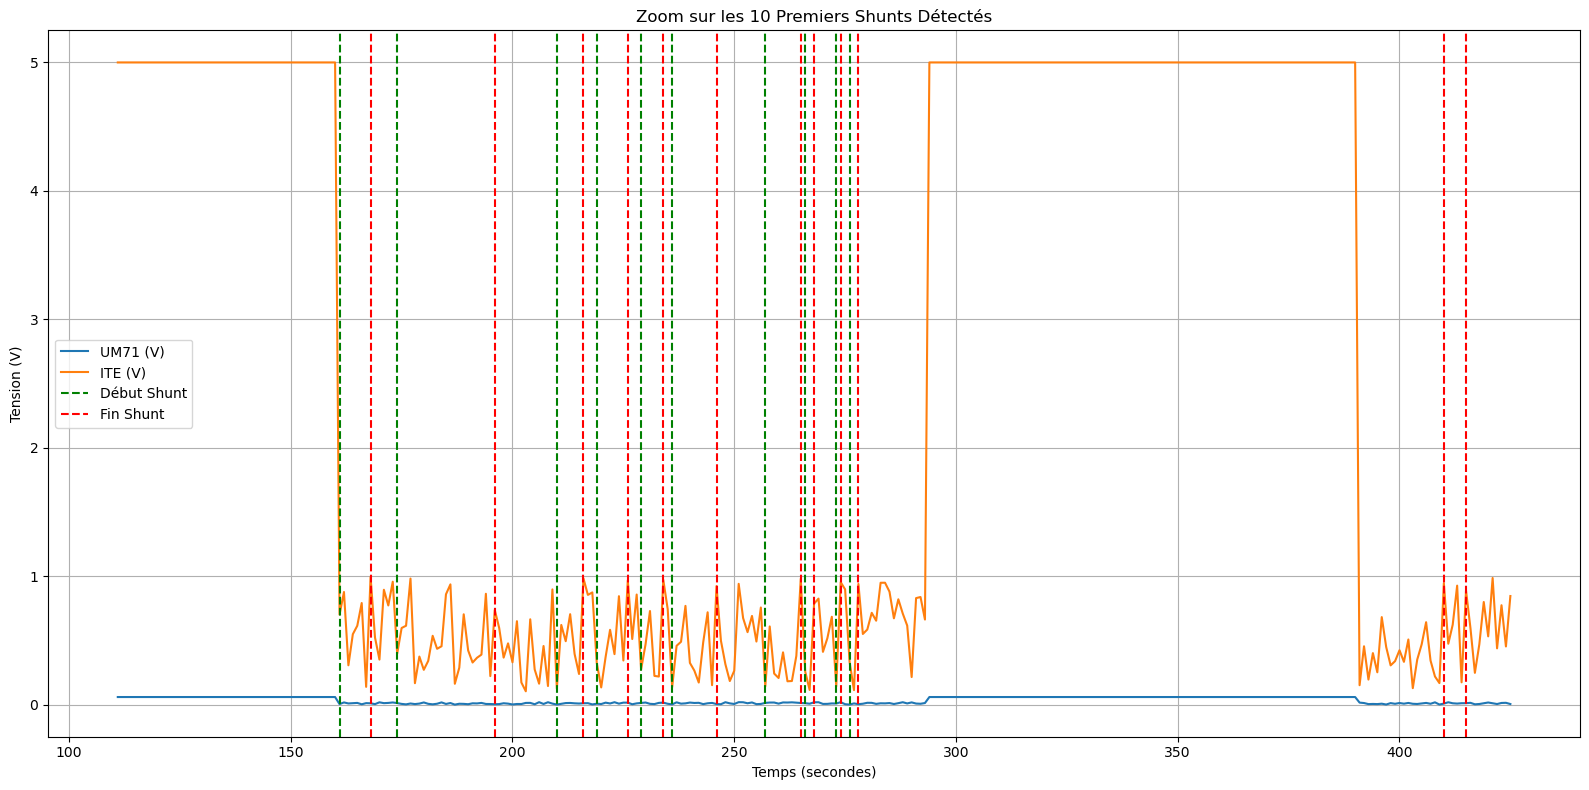

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger ton dataset à partir du fichier CSV
df = pd.read_csv('dataset_synthetique_shunt_50_trains_sans_shunt.csv')

# Ajouter la colonne 'Temps' qui incrémente les secondes
df["Temps"] = range(len(df))

# Supprimer la colonne 'Date et Heure' si elle existe
if 'Date et Heure' in df.columns:
    df = df.drop(columns=['Date et Heure'])

# Fonction pour détecter les événements de début et fin de shunt
def detect_shunt_events(df, threshold_drop=0.5):
    shunt_events = []
    shunt_started = False
    for i in range(1, len(df)):
        if (df["UM71 (V)"].iloc[i] < df["UM71 (V)"].iloc[i-1] - threshold_drop or
                df["ITE (V)"].iloc[i] < df["ITE (V)"].iloc[i-1] - threshold_drop):
            if not shunt_started:
                shunt_events.append({"Temps": df["Temps"].iloc[i], "Événement": "Début Shunt"})
                shunt_started = True
        elif shunt_started and (df["UM71 (V)"].iloc[i] > df["UM71 (V)"].iloc[i-1] + threshold_drop or
                                    df["ITE (V)"].iloc[i] > df["ITE (V)"].iloc[i-1] + threshold_drop):
            shunt_events.append({"Temps": df["Temps"].iloc[i], "Événement": "Fin Shunt"})
            shunt_started = False
    df_shunt_events = pd.DataFrame(shunt_events)
    return df_shunt_events

# Détecter les événements de shunt
df_shunt_events = detect_shunt_events(df.copy())

# Afficher les 10 premiers shunts détectés
df_premiers_shunts = df_shunt_events[df_shunt_events['Événement'] == 'Début Shunt'].head(10)

if not df_premiers_shunts.empty:
    print("Tableau des 10 Premiers Débuts de Shunt Détectés :")
    print(df_premiers_shunts)

    # Trouver les temps correspondants aux 10 premiers shunts (et quelques secondes avant/après pour le contexte)
    temps_debuts = df_premiers_shunts['Temps'].tolist()
    temps_pour_visualiser = []
    for t in temps_debuts:
        start_index = max(0, t - 50)
        end_index = min(len(df), t + 150)  # Afficher un peu plus longtemps pour voir la fin
        temps_pour_visualiser.extend(range(start_index, end_index))
    temps_pour_visualiser = sorted(list(set(temps_pour_visualiser)))
    df_zoom = df.iloc[temps_pour_visualiser]

    # Visualisation zoomée sur les 10 premiers shunts
    plt.figure(figsize=(16, 8))
    plt.plot(df_zoom['Temps'], df_zoom['UM71 (V)'], label='UM71 (V)')
    plt.plot(df_zoom['Temps'], df_zoom['ITE (V)'], label='ITE (V)')
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Tension (V)')
    plt.title('Zoom sur les 10 Premiers Shunts Détectés')
    plt.grid(True)

    # Ajouter des marqueurs pour les événements de shunt dans la zone zoomée
    for index, row in df_shunt_events[df_shunt_events['Temps'].isin(temps_debuts)].iterrows():
        plt.axvline(x=row['Temps'], color='green', linestyle='--', label='Début Shunt' if index == 0 else None)
    for index, row in df_shunt_events[df_shunt_events['Temps'] > min(temps_pour_visualiser)][df_shunt_events['Temps'] < max(temps_pour_visualiser)][df_shunt_events['Événement'] == 'Fin Shunt'].iterrows():
        plt.axvline(x=row['Temps'], color='red', linestyle='--', label='Fin Shunt' if 'Fin Shunt' not in plt.gca().get_legend_handles_labels()[1] else None)

    # Ajouter une légende sans doublons
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

else:
    print("Aucun événement de shunt détecté.")

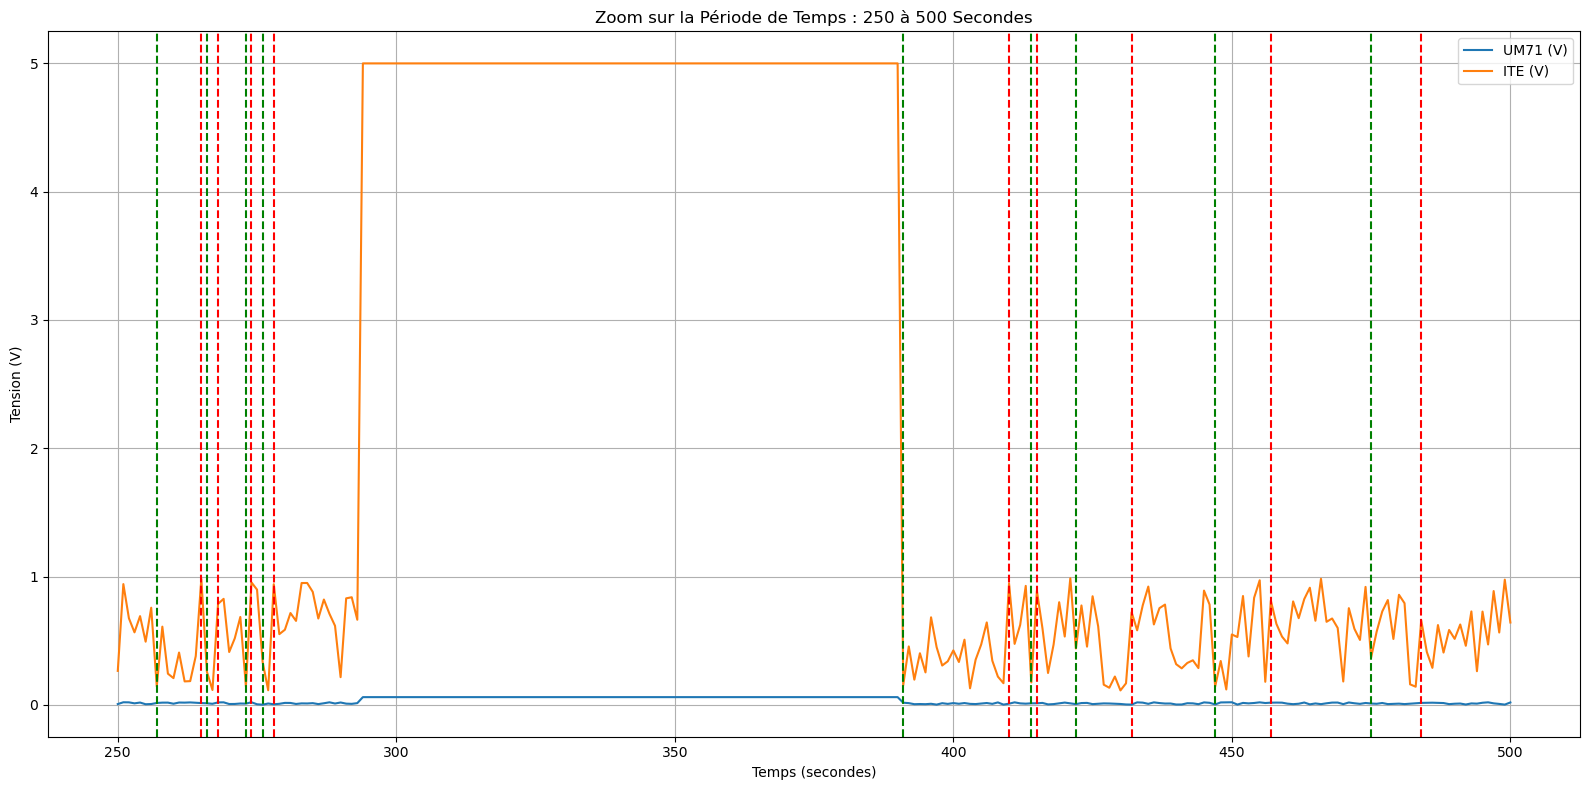

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger ton dataset à partir du fichier CSV
df = pd.read_csv('dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv') 

# Ajouter la colonne 'Temps' qui incrémente les secondes
df["Temps"] = range(len(df))

# Supprimer la colonne 'Date et Heure' si elle existe
if 'Date et Heure' in df.columns:
    df = df.drop(columns=['Date et Heure'])

# Fonction pour détecter les événements de début et fin de shunt
def detect_shunt_events(df, threshold_drop=0.5):
    shunt_events = []
    shunt_started = False
    for i in range(1, len(df)):
        if (df["UM71 (V)"].iloc[i] < df["UM71 (V)"].iloc[i-1] - threshold_drop or
                df["ITE (V)"].iloc[i] < df["ITE (V)"].iloc[i-1] - threshold_drop):
            if not shunt_started:
                shunt_events.append({"Temps": df["Temps"].iloc[i], "Événement": "Début Shunt"})
                shunt_started = True
        elif shunt_started and (df["UM71 (V)"].iloc[i] > df["UM71 (V)"].iloc[i-1] + threshold_drop or
                                    df["ITE (V)"].iloc[i] > df["ITE (V)"].iloc[i-1] + threshold_drop):
            shunt_events.append({"Temps": df["Temps"].iloc[i], "Événement": "Fin Shunt"})
            shunt_started = False
    df_shunt_events = pd.DataFrame(shunt_events)
    return df_shunt_events

# Détecter les événements de shunt
df_shunt_events = detect_shunt_events(df.copy())

# Définir la fenêtre de temps pour le zoom
temps_debut_zoom = 250
temps_fin_zoom = 500

# Sélectionner les données dans la fenêtre de temps spécifiée
df_zoom = df[(df['Temps'] >= temps_debut_zoom) & (df['Temps'] <= temps_fin_zoom)]

# Visualisation zoomée
plt.figure(figsize=(16, 8))
plt.plot(df_zoom['Temps'], df_zoom['UM71 (V)'], label='UM71 (V)')
plt.plot(df_zoom['Temps'], df_zoom['ITE (V)'], label='ITE (V)')
plt.xlabel('Temps (secondes)')
plt.ylabel('Tension (V)')
plt.title(f'Zoom sur la Période de Temps : {temps_debut_zoom} à {temps_fin_zoom} Secondes')
plt.grid(True)

# Ajouter des marqueurs pour les événements de shunt dans la zone zoomée
for index, row in df_shunt_events[
    (df_shunt_events['Temps'] >= temps_debut_zoom) & (df_shunt_events['Temps'] <= temps_fin_zoom)
].iterrows():
    color = 'green' if row['Événement'] == 'Début Shunt' else 'red'
    plt.axvline(x=row['Temps'], color=color, linestyle='--', label=row['Événement'] if index == 0 else None)

# Ajouter une légende sans doublons
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

## 2-Caractériser, sur ces courbes, toute anomalie représentant une tension résiduelle (TR) et procéder au traitement adéquat en cas de détection automatique (invalidation, historisation, alerte…)

In [31]:
import pandas as pd
import numpy as np

# Seuils normatifs
SEUIL_UM71_SHUNT = 0.06
SEUIL_ITE_SHUNT = 5.0

# Seuils pour détecter une tension résiduelle (à ajuster selon vos observations)
SEUIL_TR_UM71_HAUT = 0.15  # Tension légèrement au-dessus du seuil de shunt UM71
SEUIL_TR_ITE_BAS = 6.0    # Tension légèrement au-dessus du seuil de shunt ITE

def detect_tr(df, temps_min_tr=5):
    """
    Détecte automatiquement les anomalies potentielles de Tension Résiduelle (TR).

    Args:
        df (pd.DataFrame): DataFrame avec les colonnes 'Temps', 'UM71 (V)', 'ITE (V)'.
        temps_min_tr (int): Durée minimale (en secondes) pendant laquelle la tension anormale doit persister pour être considérée comme une TR potentielle.

    Returns:
        pd.DataFrame: DataFrame des anomalies potentielles de TR détectées.
    """
    tr_anomalies = []

    # Détection TR pour UM71
    df['UM71_TR_Potentielle'] = np.where(df['UM71 (V)'] > SEUIL_UM71_SHUNT,
                                         np.where(df['UM71 (V)'] <= SEUIL_TR_UM71_HAUT, 1, 0), 0)
    df['UM71_TR_Debut'] = df['UM71_TR_Potentielle'].diff() == 1
    df['UM71_TR_Fin'] = df['UM71_TR_Potentielle'].diff() == -1

    debuts_tr_um71 = df[df['UM71_TR_Debut']]['Temps'].tolist()
    fins_tr_um71 = df[df['UM71_TR_Fin']]['Temps'].tolist()

    # Associer les débuts et fins de TR UM71 et filtrer par durée
    for debut in debuts_tr_um71:
        fin_possible = [fin for fin in fins_tr_um71 if fin > debut]
        if fin_possible:
            fin = min(fin_possible)
            duree_tr = fin - debut
            if duree_tr >= temps_min_tr:
                tr_anomalies.append({'Temps Début': debut, 'Temps Fin': fin, 'Durée (s)': duree_tr, 'Circuit': 'UM71', 'Type Anomalie': 'Tension Résiduelle'})
            if fin in fins_tr_um71:
                fins_tr_um71.remove(fin) # Éviter de réutiliser la même fin

    # Détection TR pour ITE
    df['ITE_TR_Potentielle'] = np.where(df['ITE (V)'] < SEUIL_ITE_SHUNT,
                                        np.where(df['ITE (V)'] >= SEUIL_TR_ITE_BAS, 1, 0), 0)
    df['ITE_TR_Debut'] = df['ITE_TR_Potentielle'].diff() == 1
    df['ITE_TR_Fin'] = df['ITE_TR_Potentielle'].diff() == -1

    debuts_tr_ite = df[df['ITE_TR_Debut']]['Temps'].tolist()
    fins_tr_ite = df[df['ITE_TR_Fin']]['Temps'].tolist()

    # Associer les débuts et fins de TR ITE et filtrer par durée
    for debut in debuts_tr_ite:
        fin_possible = [fin for fin in fins_tr_ite if fin > debut]
        if fin_possible:
            fin = min(fin_possible)
            duree_tr = fin - debut
            if duree_tr >= temps_min_tr:
                tr_anomalies.append({'Temps Début': debut, 'Temps Fin': fin, 'Durée (s)': duree_tr, 'Circuit': 'ITE', 'Type Anomalie': 'Tension Résiduelle'})
            if fin in fins_tr_ite:
                fins_tr_ite.remove(fin) # Éviter de réutiliser la même fin

    return pd.DataFrame(tr_anomalies)

# Charger votre dataset
df = pd.read_csv('dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv')
df["Temps"] = range(len(df))

# Détecter les anomalies potentielles de TR
df_tr_anomalies = detect_tr(df.copy())

if not df_tr_anomalies.empty:
    print("Anomalies Potentielles de Tension Résiduelle (TR) Détectées :")
    print(df_tr_anomalies)

    # Traitement adéquat (exemple : marquer les données)
    df['Anomalie TR'] = False
    for index, row in df_tr_anomalies.iterrows():
        df.loc[(df['Temps'] >= row['Temps Début']) & (df['Temps'] <= row['Temps Fin']), 'Anomalie TR'] = True

    print("\nPremières lignes du DataFrame avec marquage des anomalies TR :")
    print(df.head(20))

    # Visualisation des anomalies TR
    plt.figure(figsize=(16, 8))
    plt.plot(df['Temps'], df['UM71 (V)'], label='UM71 (V)')
    plt.plot(df['Temps'], df['ITE (V)'], label='ITE (V)')
    plt.xlabel('Temps (secondes)')
    plt.ylabel('Tension (V)')
    plt.title('Signaux de Tension avec Anomalies TR Détectées')
    plt.grid(True)

    # Marquer les périodes d'anomalie TR
    for index, row in df_tr_anomalies.iterrows():
        plt.axvspan(row['Temps Début'], row['Temps Fin'], color='orange', alpha=0.3, label='Anomalie TR' if index == 0 else None)

    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Aucune anomalie de Tension Résiduelle (TR) détectée selon les critères définis.")

Aucune anomalie de Tension Résiduelle (TR) détectée selon les critères définis.


In [33]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv")

# Afficher toutes les lignes où la valeur de la colonne 'TR' est strictement supérieure à 0
df_tr_sup_zero = df[df['TR'] > 0]

if not df_tr_sup_zero.empty:
    print("Lignes où la valeur de la colonne 'TR' est supérieure à 0:")
    print(df_tr_sup_zero)
else:
    print("Aucune ligne avec une valeur de 'TR' supérieure à 0 trouvée.")

Lignes où la valeur de la colonne 'TR' est supérieure à 0:
       Temps (s)  UM71 (V)  ITE (V)  TR    Date et Heure
300          300   0.06000  5.00000   6  0 days 00:05:00
1800        1800   0.06000  5.00000   3  0 days 00:30:00
3600        3600   0.00469  0.52485   5  0 days 01:00:00
5400        5400   0.01586  0.59219   2  0 days 01:30:00
7500        7500   0.06000  5.00000   1  0 days 02:05:00
9600        9600   0.06000  5.00000  10  0 days 02:40:00
13800      13800   0.01927  0.75699   1  0 days 03:50:00
14400      14400   0.06000  5.00000  11  0 days 04:00:00
15900      15900   0.06000  5.00000   8  0 days 04:25:00
20100      20100   0.06000  5.00000  10  0 days 05:35:00


### Analyser les occurrences des TR et les corréler avec des données internes et externes pour capter les signaux faibles liés à l’état des voies en prévision d’actions de maintenance.

In [35]:
import pandas as pd

# Charger le dataset
df = pd.read_csv("dataset_synthetique_shunt_50_trains_sans_shunt_tf.csv")

# Afficher les statistiques descriptives de la colonne 'TR'
print("Étendue des valeurs de la colonne 'TR':")
print(df['TR'].describe())

# Afficher les valeurs uniques présentes dans la colonne 'TR'
print("\nValeurs uniques dans la colonne 'TR':")
print(df['TR'].unique())

# Afficher le nombre d'occurrences de chaque valeur dans la colonne 'TR'
print("\nNombre d'occurrences de chaque valeur dans la colonne 'TR':")
print(df['TR'].value_counts().sort_index())

Étendue des valeurs de la colonne 'TR':
count    21600.000000
mean         0.002639
std          0.146071
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: TR, dtype: float64

Valeurs uniques dans la colonne 'TR':
[ 0  6  3  5  2  1 10 11  8]

Nombre d'occurrences de chaque valeur dans la colonne 'TR':
TR
0     21590
1         2
2         1
3         1
5         1
6         1
8         1
10        2
11        1
Name: count, dtype: int64


### CREATION DE LA CLASSE SHUNT

In [111]:
import pandas as pd
import numpy as np

def detect_shunt_algo(df):
    """
    Crée une colonne 'shunt_algo' dans le DataFrame et attribue la valeur 1
    si UM71 est strictement inférieur à 0.06 et ITE est strictement inférieur à 5.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes 'UM71 (V)' et 'ITE (V)'.

    Returns:
        pd.DataFrame: Le DataFrame avec la nouvelle colonne 'shunt_algo'.
    """
    df['shunt_algo'] = 0  # Initialise la colonne 'shunt_algo' à 0
    condition_shunt = (df['UM71 (V)'] < 0.06) & (df['ITE (V)'] < 5)
    df.loc[condition_shunt, 'shunt_algo'] = 1
    return df

# Nom du fichier CSV
csv_file = "dataset_synthetique_shunt_50_trains_sans_shunt.csv"

# Charger le dataset
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Erreur: Le fichier '{csv_file}' n'a pas été trouvé.")
    exit()

# Appliquer la fonction pour créer la colonne 'shunt_algo'
df = detect_shunt_algo(df.copy())

# Création de la colonne 'id' pour toutes les séquences (shunt et non-shunt)
df['id'] = 0
sequence_counter = 0
in_sequence = False
current_value = -1  # Pour suivre la valeur de 'shunt_algo' de la séquence actuelle

for index, row in df.iterrows():
    shunt_value = row['shunt_algo']
    if not in_sequence:
        in_sequence = True
        sequence_counter += 1
        df.loc[index, 'id'] = sequence_counter
        current_value = shunt_value
    elif in_sequence and shunt_value == current_value:
        df.loc[index, 'id'] = sequence_counter
    elif in_sequence and shunt_value != current_value:
        in_sequence = True
        sequence_counter += 1
        df.loc[index, 'id'] = sequence_counter
        current_value = shunt_value

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes (pour vérification)
print("Premières lignes du DataFrame avec 'shunt_algo' et 'id':")
print(df.head(20))

# Afficher la distribution des valeurs dans la colonne 'shunt_algo' (pour vérification)
print("\nDistribution de la colonne 'shunt_algo':")
print(df['shunt_algo'].value_counts())

# Afficher la distribution des valeurs dans la colonne 'id' (pour vérification)
print("\nDistribution de la colonne 'id':")
print(df['id'].value_counts().sort_index())

# Sauvegarder le DataFrame modifié dans un nouveau fichier CSV
output_csv_file = "dataset_synthetique_shunt_50_trains_avec_sequence_id.csv"
df.to_csv(output_csv_file, index=False)

print(f"\nLe DataFrame avec les colonnes 'shunt_algo' et 'id' a été sauvegardé dans '{output_csv_file}'.")

Premières lignes du DataFrame avec 'shunt_algo' et 'id':
    Temps (s)  UM71 (V)  ITE (V)  TR    Date et Heure  shunt_algo  id
0           0      0.06      5.0   0  0 days 00:00:00           0   1
1           1      0.06      5.0   0  0 days 00:00:01           0   1
2           2      0.06      5.0   0  0 days 00:00:02           0   1
3           3      0.06      5.0   0  0 days 00:00:03           0   1
4           4      0.06      5.0   0  0 days 00:00:04           0   1
5           5      0.06      5.0   0  0 days 00:00:05           0   1
6           6      0.06      5.0   0  0 days 00:00:06           0   1
7           7      0.06      5.0   0  0 days 00:00:07           0   1
8           8      0.06      5.0   0  0 days 00:00:08           0   1
9           9      0.06      5.0   0  0 days 00:00:09           0   1
10         10      0.06      5.0   0  0 days 00:00:10           0   1
11         11      0.06      5.0   0  0 days 00:00:11           0   1
12         12      0.06      5.0 

In [113]:
df


,Temps (s),UM71 (V),ITE (V),TR,Date et Heure,shunt_algo,id
0,0,0.06,5.0,0,0 days 00:00:00,0,1
1,1,0.06,5.0,0,0 days 00:00:01,0,1
2,2,0.06,5.0,0,0 days 00:00:02,0,1
3,3,0.06,5.0,0,0 days 00:00:03,0,1
4,4,0.06,5.0,0,0 days 00:00:04,0,1
...,...,...,...,...,...,...,...
21595,21595,0.06,5.0,0,0 days 05:59:55,0,99
21596,21596,0.06,5.0,0,0 days 05:59:56,0,99
21597,21597,0.06,5.0,0,0 days 05:59:57,0,99
21598,21598,0.06,5.0,0,0 days 05:59:58,0,99


### NOMBRE ET DUREE ET HEURE DE TOUS LES  SHUNT 

In [119]:
import pandas as pd
import numpy as np

def detect_shunt_algo(df):
    """
    Crée une colonne 'shunt_algo' dans le DataFrame et attribue la valeur 1
    si UM71 est strictement inférieur à 0.06 et ITE est strictement inférieur à 5.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes 'UM71 (V)' et 'ITE (V)'.

    Returns:
        pd.DataFrame: Le DataFrame avec la nouvelle colonne 'shunt_algo'.
    """
    df['shunt_algo'] = 0  # Initialise la colonne 'shunt_algo' à 0
    condition_shunt = (df['UM71 (V)'] < 0.06) & (df['ITE (V)'] < 5)
    df.loc[condition_shunt, 'shunt_algo'] = 1
    return df

# Nom du fichier CSV
csv_file = "dataset_synthetique_shunt_50_trains_avec_sequence_id.csv"

# Charger le dataset
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Erreur: Le fichier '{csv_file}' n'a pas été trouvé.")
    exit()

# Appliquer la fonction pour créer la colonne 'shunt_algo'
df = detect_shunt_algo(df.copy())

# Création de la colonne 'shunt_id' pour identifier les séquences de shunts
df['shunt_id'] = 0
shunt_counter = 0
in_shunt = False

for index, row in df.iterrows():
    if row['shunt_algo'] == 1:
        if not in_shunt:
            in_shunt = True
            shunt_counter += 1
        df.loc[index, 'shunt_id'] = shunt_counter
    else:
        in_shunt = False

# Filtrer le DataFrame pour ne garder que les lignes où shunt_algo est 1
shunt_only_df = df[df['shunt_algo'] == 1]

# Obtenir la liste des IDs de shunt uniques
liste_ids_shunt = shunt_only_df['shunt_id'].unique().tolist()

# Afficher la liste des IDs de shunt
print("Liste des IDs des séquences où shunt_algo est égal à 1:")
print(liste_ids_shunt)

# Si vous voulez voir le DataFrame complet avec la colonne 'shunt_id' :
print("\nDataFrame complet avec la colonne 'shunt_id':")
print(df.head())

# Si vous voulez voir uniquement les lignes où shunt_algo est 1 avec leur ID :
print("\nLignes où shunt_algo est égal à 1 avec leur 'shunt_id':")
print(shunt_only_df)

Liste des IDs des séquences où shunt_algo est égal à 1:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

DataFrame complet avec la colonne 'shunt_id':
   Temps (s)  UM71 (V)  ITE (V)  TR    Date et Heure  shunt_algo  id  shunt_id
0          0      0.06      5.0   0  0 days 00:00:00           0   1         0
1          1      0.06      5.0   0  0 days 00:00:01           0   1         0
2          2      0.06      5.0   0  0 days 00:00:02           0   1         0
3          3      0.06      5.0   0  0 days 00:00:03           0   1         0
4          4      0.06      5.0   0  0 days 00:00:04           0   1         0

Lignes où shunt_algo est égal à 1 avec leur 'shunt_id':
       Temps (s)  UM71 (V)  ITE (V)  TR    Date et Heure  shunt_algo  id  \
161          161   0.00483  0.70203   0  0 days 00:02:41           1   2   
162          162   0.01802

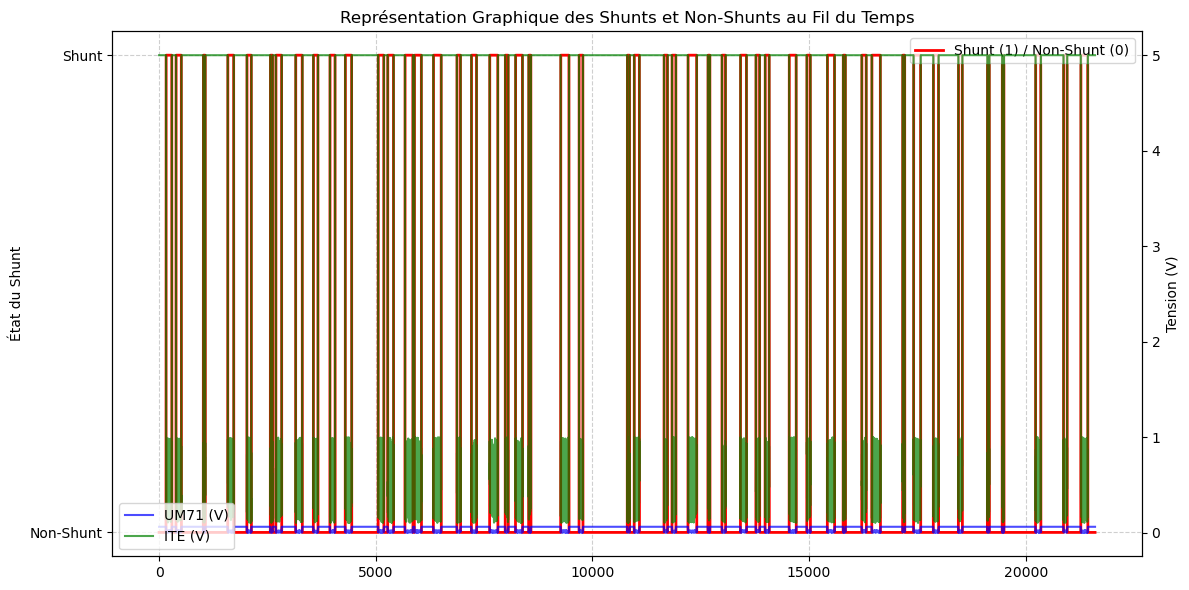

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_shunt_status(df, shunt_column='shunt_algo', time_column='Temps (s)',
                      um71_column='UM71 (V)', ite_column='ITE (V)'):
    """
    Crée un graphique représentant l'état de shunt (0 ou 1) au fil du temps,
    ainsi que les signaux de tension UM71 et ITE.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données.
        shunt_column (str): Le nom de la colonne binaire (0 ou 1) indiquant la présence de shunt.
        time_column (str): Le nom de la colonne contenant le temps en secondes.
        um71_column (str): Le nom de la colonne contenant la tension UM71.
        ite_column (str): Le nom de la colonne contenant la tension ITE.
    """
    plt.figure(figsize=(12, 6))

    # Tracer l'état de shunt
    plt.plot(df[time_column], df[shunt_column], label='Shunt (1) / Non-Shunt (0)', color='red', linewidth=2)
    plt.yticks([0, 1], ['Non-Shunt', 'Shunt'])
    plt.ylabel('État du Shunt')
    plt.title('Représentation Graphique des Shunts et Non-Shunts au Fil du Temps')
    plt.grid(True, which='major', linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')

    # Ajouter un deuxième axe y pour les tensions
    ax2 = plt.gca().twinx()
    ax2.plot(df[time_column], df[um71_column], label='UM71 (V)', color='blue', alpha=0.7)
    ax2.plot(df[time_column], df[ite_column], label='ITE (V)', color='green', alpha=0.7)
    ax2.set_ylabel('Tension (V)')
    ax2.legend(loc='lower left')

    plt.xlabel('Temps (s)')
    plt.tight_layout()
    plt.show()

# Charger votre dataset
df = pd.read_csv("dataset_synthetique_shunt_50_trains_avec_sequence_id.csv")

# Créer la colonne 'shunt_algo' si elle n'existe pas déjà
if 'shunt_algo' not in df.columns:
    def detect_shunt_algo(df):
        df['shunt_algo'] = 0
        condition_shunt = (df['UM71 (V)'] < 0.06) & (df['ITE (V)'] < 5)
        df.loc[condition_shunt, 'shunt_algo'] = 1
        return df
    df = detect_shunt_algo(df.copy())

# Générer le graphique
plot_shunt_status(df)

### VISUALISER DE LA REPARTITION DES CLASSES

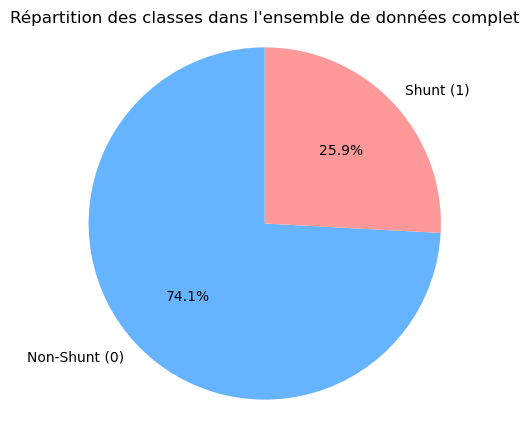

In [136]:
import matplotlib.pyplot as plt

# Fonction pour créer un pie chart avec les pourcentages
def create_pie_chart(data, title):
    counts = data.value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=['Non-Shunt (0)', 'Shunt (1)'], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Pour visualiser la distribution dans l'ensemble de données complet
create_pie_chart(df['shunt_algo'], 'Répartition des classes dans l\'ensemble de données complet')


### LSTM POUR DETECTER LES SHUNT

Epoch 1/30


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.4815 - f1_metric: nan - loss: nan - precision: 0.2674 - recall: 0.5725 - val_accuracy: 0.7401 - val_f1_metric: nan - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7404 - f1_metric: nan - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7401 - val_f1_metric: nan - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.7426 - f1_metric: nan - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7401 - val_f1_metric: nan - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.7356 - f1_metric: nan - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7401 - val_f1_metric: nan - val_loss: nan - val_precision: 0.0000e+00 - va

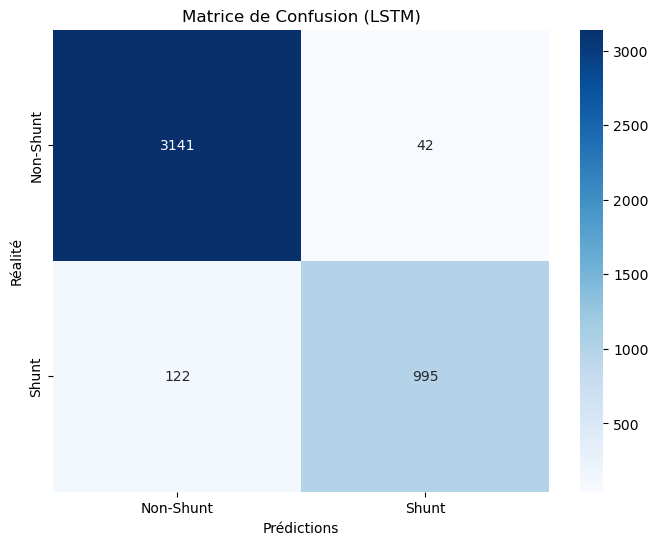

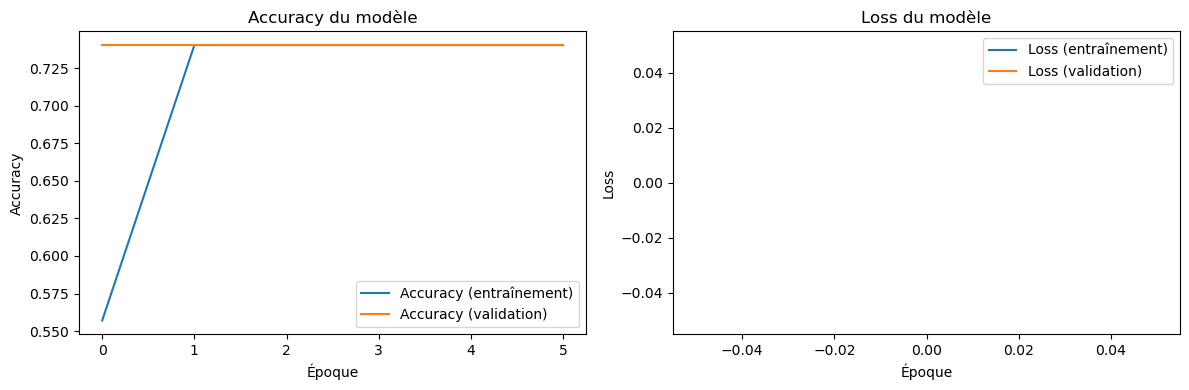


Distribution des vrais labels (y_test):
0    3183
1    1117
Name: count, dtype: int64

Distribution des prédictions (predictions_binary):
0    4300
Name: count, dtype: int64


In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score as sk_f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Préparation des données
df = pd.read_csv("dataset_synthetique_shunt_50_trains_avec_sequence_id.csv")
features = ['Temps (s)', 'UM71 (V)', 'ITE (V)']
X = df[features].values
y = df['shunt_algo'].values.reshape(-1, 1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
sequence_length = 100

def create_sequences_with_id(df, sequence_length):
    X_seq, y_seq, id_seq = [], [], []
    for i in range(len(df) - sequence_length):
        X_seq.append(df[['Temps (s)', 'UM71 (V)', 'ITE (V)']].iloc[i:i+sequence_length].values)
        y_seq.append(df['shunt_algo'].iloc[i+sequence_length-1])
        id_seq.append(df['id'].iloc[i+sequence_length-1])
    return np.array(X_seq), np.array(y_seq).reshape(-1, 1), np.array(id_seq).reshape(-1, 1)

X_seq, y_seq, id_seq = create_sequences_with_id(df, sequence_length)
X_train_id, X_test_id, y_train_id, y_test_id, id_train, id_test = train_test_split(
    X_seq, y_seq, id_seq, test_size=0.2, random_state=42, stratify=y_seq
)
X_train, X_val, y_train, y_val, id_train_split, id_val_split = train_test_split(
    X_train_id, y_train_id, id_train, test_size=0.2, random_state=42, stratify=y_train_id
)

# 2. Définition du modèle LSTM
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# 3. Définition d'une fonction pour calculer le F1-score (using Keras backend)
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# 4. Compilation du modèle with the custom F1-score metric
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall', f1_metric])

# 5. Entraînement du modèle
epochs = 30
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# 6. Évaluation du modèle and calculation of metrics (using scikit-learn for F1 on test set)
loss, accuracy, precision, recall, f1_val_train = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)
f1_test = sk_f1_score(y_test, predictions_binary)

print(f"Loss sur l'ensemble de test: {loss:.4f}")
print(f"Accuracy sur l'ensemble de test: {accuracy:.4f}")
print(f"Précision sur l'ensemble de test: {precision:.4f}")
print(f"Rappel (Sensitivity) sur l'ensemble de test: {recall:.4f}")
print(f"F1-Score sur l'ensemble de test (Keras during train): {f1_val_train:.4f}")
print(f"F1-Score sur l'ensemble de test (scikit-learn): {f1_test:.4f}")

# 7. Analyse des performances par séquence ('id')
analysis_df = pd.DataFrame({'true_shunt': y_test.flatten(),
                            'predicted_shunt': predictions_binary.flatten(),
                            'id': id_test.flatten()})

performance_per_sequence = analysis_df.groupby('id').agg(
    true_positive=('true_shunt', lambda x: np.sum((x == 1) & (analysis_df.loc[x.index, 'predicted_shunt'] == 1))),
    false_positive=('true_shunt', lambda x: np.sum((x == 0) & (analysis_df.loc[x.index, 'predicted_shunt'] == 1))),
    true_negative=('true_shunt', lambda x: np.sum((x == 0) & (analysis_df.loc[x.index, 'predicted_shunt'] == 0))),
    false_negative=('true_shunt', lambda x: np.sum((x == 1) & (analysis_df.loc[x.index, 'predicted_shunt'] == 0))),
    majority_true=('true_shunt', lambda x: 1 if x.sum() > len(x) / 2 else 0),
    majority_predicted=('predicted_shunt', lambda x: 1 if x.sum() > len(x) / 2 else 0)
).reset_index()

print("\nPerformance par séquence (agrégée par majorité):")
print(performance_per_sequence)

sequence_precision = precision_score(performance_per_sequence['majority_true'], performance_per_sequence['majority_predicted'], zero_division=0)
sequence_recall = recall_score(performance_per_sequence['majority_true'], performance_per_sequence['majority_predicted'], zero_division=0)
sequence_f1 = f1_score(performance_per_sequence['majority_true'], performance_per_sequence['majority_predicted'], zero_division=0)

print(f"\nPrécision au niveau de la séquence: {sequence_precision:.4f}")
print(f"Rappel au niveau de la séquence: {sequence_recall:.4f}")
print(f"F1-Score au niveau de la séquence: {sequence_f1:.4f}")

# 8. Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Shunt', 'Shunt'], yticklabels=['Non-Shunt', 'Shunt'])
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (LSTM)')
plt.show()

# 9. Visualisation de l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy du modèle')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (entraînement)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss du modèle')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# -- Affichage des distributions pour vérification --
print("\nDistribution des vrais labels (y_test):")
print(pd.Series(y_test.flatten()).value_counts())

print("\nDistribution des prédictions (predictions_binary):")
print(pd.Series(predictions_binary.flatten()).value_counts())

### ANALYSER LES SHUNT AU LIEU DES OCCURENCES

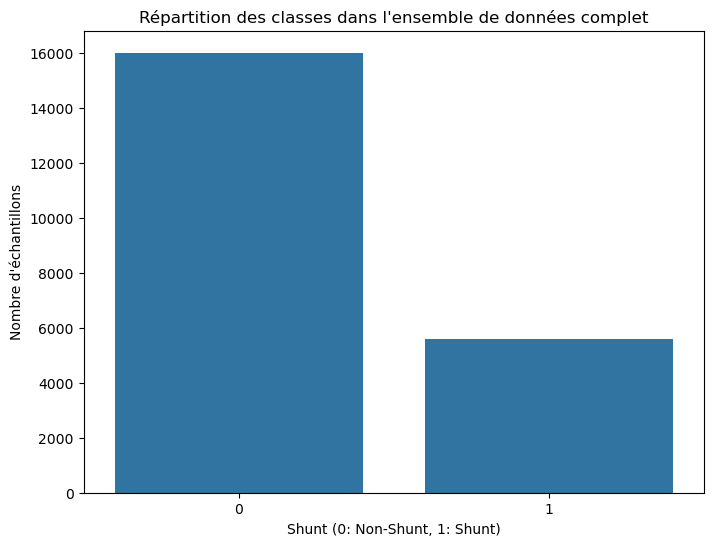

Fold 1/5


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.5040 - f1_metric: 0.4685 - loss: 216225.9688 - val_accuracy: 0.7363 - val_f1_metric: 0.0664 - val_loss: 123906.6406
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.5096 - f1_metric: 0.4491 - loss: 237582.6094 - val_accuracy: 0.2791 - val_f1_metric: 0.4064 - val_loss: 312392.6250
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.5066 - f1_metric: 0.4401 - loss: 204956.1875 - val_accuracy: 0.2791 - val_f1_metric: 0.3900 - val_loss: 21434.3242
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.4987 - f1_metric: 0.4798 - loss: 60160.0586 - val_accuracy: 0.6436 - val_f1_metric: 0.2488 - val_loss: 28361.0566
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.5017 - f1_metric: 0.4788 - loss: 26144.6621 - val_accuracy: 0.6134 - val_f1_metric: 0.2609 - val_loss: 2915.2183
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.5088 - f1_me

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.5000 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.5049 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.4994 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - accuracy: 0.4964 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.4944 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.5014 - f1_metric: nan - loss: nan - val_accuracy: 0.7404 - val_f1_metric: nan - val_loss: nan
Epoch 7/30
319/319 ━━━━━━━━━━━━━━

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.4884 - f1_metric: 0.4420 - loss: 581037.6250 - val_accuracy: 0.3605 - val_f1_metric: 0.3418 - val_loss: 224531.1250
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.5023 - f1_metric: 0.4975 - loss: 209503.6094 - val_accuracy: 0.5140 - val_f1_metric: 0.3986 - val_loss: 18759.5391
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - accuracy: 0.5036 - f1_metric: 0.4865 - loss: 35346.3086 - val_accuracy: 0.4814 - val_f1_metric: 0.3151 - val_loss: 13585.7510
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.5065 - f1_metric: 0.5144 - loss: 18312.9336 - val_accuracy: 0.3820 - val_f1_metric: 0.3994 - val_loss: 3019.4951
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.5013 - f1_metric: 0.4940 - loss: 6462.0107 - val_accuracy: 0.3323 - val_f1_metric: 0.3879 - val_loss: 7901.6714
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.5101 - f1_metric: 0.5005 - 

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 49s 143ms/step - accuracy: 0.5083 - f1_metric: 0.4272 - loss: 248069.3594 - val_accuracy: 0.7270 - val_f1_metric: 0.0514 - val_loss: 153068.3750
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.4975 - f1_metric: 0.4463 - loss: 117826.8281 - val_accuracy: 0.6860 - val_f1_metric: 0.1079 - val_loss: 2499.1890
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.5024 - f1_metric: 0.4646 - loss: 12551.3672 - val_accuracy: 0.4767 - val_f1_metric: 0.3401 - val_loss: 2928.8159
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 138ms/step - accuracy: 0.5005 - f1_metric: 0.4760 - loss: 18679.9492 - val_accuracy: 0.4198 - val_f1_metric: 0.3525 - val_loss: 3826.1047
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.4930 - f1_metric: 0.5430 - loss: 9191.9619 - val_accuracy: 0.2797 - val_f1_metric: 0.4018 - val_loss: 34644.1797
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.4992 - f1_metric: 0.4416 - l

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 45s 122ms/step - accuracy: 0.4999 - f1_metric: 0.5530 - loss: 2540435.5000 - val_accuracy: 0.3512 - val_f1_metric: 0.3352 - val_loss: 814693.5000
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.4953 - f1_metric: 0.4879 - loss: 100325.0000 - val_accuracy: 0.5250 - val_f1_metric: 0.4104 - val_loss: 24326.3809
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.5059 - f1_metric: 0.4976 - loss: 48628.7773 - val_accuracy: 0.6474 - val_f1_metric: 0.1893 - val_loss: 16431.2910
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.5043 - f1_metric: 0.4635 - loss: 42396.3125 - val_accuracy: 0.4110 - val_f1_metric: 0.3716 - val_loss: 548.4716
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.5012 - f1_metric: 0.4472 - loss: 3799.7803 - val_accuracy: 0.5186 - val_f1_metric: 0.3198 - val_loss: 307.0207
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.5019 - f1_metric: 0.4126 - l

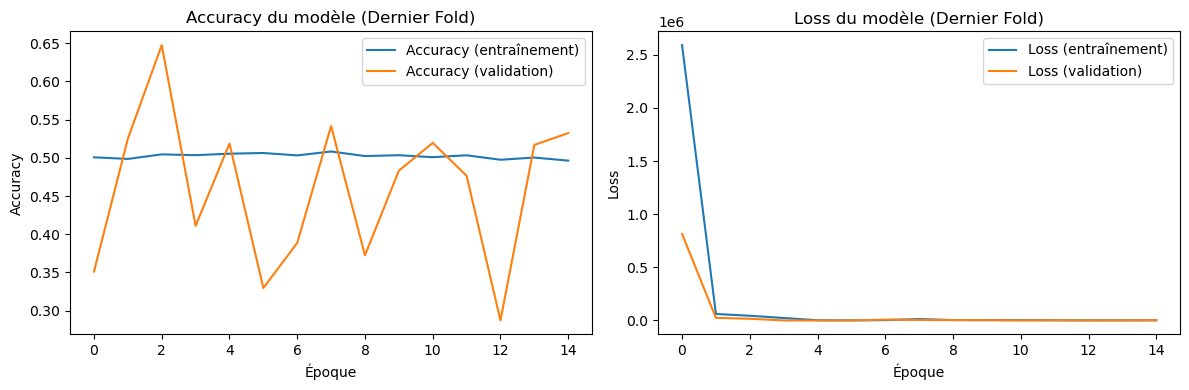

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score as sk_f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# 1. Préparation des données
df = pd.read_csv("dataset_synthetique_shunt_50_trains_avec_sequence_id.csv")
features = ['Temps (s)', 'UM71 (V)', 'ITE (V)']
X = df[features].values
y = df['shunt_algo'].values

sequence_length = 100

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length]) # Label à la fin de la séquence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, sequence_length)
y_seq = y_seq.reshape(-1, 1)

# Visualisation de la répartition des classes
plt.figure(figsize=(8, 6))
sns.countplot(x=df['shunt_algo'])
plt.title('Répartition des classes dans l\'ensemble de données complet')
plt.xlabel('Shunt (0: Non-Shunt, 1: Shunt)')
plt.ylabel('Nombre d\'échantillons')
plt.show()

# Division en ensembles d'entraînement et de test (pour la CV interne)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# Fonction pour créer le modèle LSTM
def create_lstm_model(sequence_length, n_features, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_metric])
    return model

# Définition de la fonction f1_metric (assurez-vous qu'elle est définie comme précédemment)
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Préparation pour la cross-validation stratifiée
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
f1_scores = []
histories = []
cms = []

n_features = X_train_val.shape[2] # Récupérer le nombre de features

for fold, (train_index, val_index) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"Fold {fold+1}/{n_splits}")
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

    # Gestion du déséquilibre avec SMOTE (uniquement sur l'ensemble d'entraînement du fold)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold.flatten())
    X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], sequence_length, n_features)
    y_train_resampled = y_train_resampled.reshape(-1, 1)

    # Calcul des poids de classe après le suréchantillonnage
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled.flatten()), y=y_train_resampled.flatten())
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    model = create_lstm_model(sequence_length, n_features)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=64,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping],
                        class_weight=class_weight_dict, verbose=1)
    histories.append(history)

    y_pred_fold = (model.predict(X_val_fold) > 0.5).astype(int)
    f1 = sk_f1_score(y_val_fold, y_pred_fold)
    f1_scores.append(f1)
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    cms.append(cm)
    print(f"F1-Score pour le fold {fold+1}: {f1:.4f}")
    print(f"Matrice de Confusion pour le fold {fold+1}:\n[[{cm[1, 1]} {cm[1, 0]}]\n [{cm[0, 1]} {cm[0, 0]}]]") # Affichage modifié

print(f"\nMoyenne des F1-Scores sur {n_splits} folds: {np.mean(f1_scores):.4f}")
print(f"Matrices de Confusion par fold:\n{[np.array([[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]]) for cm in cms]}") # Affichage modifié

# Évaluation finale sur l'ensemble de test (en utilisant le modèle du dernier fold)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)
loss_test, accuracy_test, f1_test = model.evaluate(X_test, y_test, verbose=0)
cm_test = confusion_matrix(y_test, y_pred_test)

print("\nPerformances sur l'ensemble de test:")
print(f"Loss: {loss_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"Matrice de Confusion sur l'ensemble de test:\n[[{cm_test[1, 1]} {cm_test[1, 0]}]\n [{cm_test[0, 1]} {cm_test[0, 0]}]]") # Affichage modifié

# Visualisation de l'historique d'entraînement (pour le dernier fold)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories[-1].history['accuracy'], label='Accuracy (entraînement)')
plt.plot(histories[-1].history['val_accuracy'], label='Accuracy (validation)')
plt.title('Accuracy du modèle (Dernier Fold)')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(histories[-1].history['loss'], label='Loss (entraînement)')
plt.plot(histories[-1].history['val_loss'], label='Loss (validation)')
plt.title('Loss du modèle (Dernier Fold)')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Analyse des performances par séquence ('id') sur l'ensemble de test
# (Nécessite de réintégrer la colonne 'id' dans l'ensemble de test des séquences)
# Cette partie est plus complexe car la division en séquences et train/test a mélangé l'ordre.
# Une approche plus robuste serait de conserver l'information 'id' lors de la création des séquences
# et de s'assurer de son alignement avec les prédictions sur l'ensemble de test.

# Si vous aviez conservé 'id' lors de la création des séquences et de la division:
# analysis_df_test = pd.DataFrame({'true_shunt': y_test.flatten(),
#                                   'predicted_shunt': y_pred_test.flatten(),
#                                   'id': id_test.flatten()})
#
# performance_per_sequence_test = analysis_df_test.groupby('id').agg(
#     majority_true=('true_shunt', lambda x: 1 if x.sum() > len(x) / 2 else 0),
#     majority_predicted=('predicted_shunt', lambda x: 1 if x.sum() > len(x) / 2 else 0)
# ).reset_index()
#
# cm_sequence_test = confusion_matrix(performance_per_sequence_test['majority_true'], performance_per_sequence_test['majority_predicted'])
# print("\nMatrice de Confusion au niveau de la séquence (Ensemble de Test):\n", cm_sequence_test)

## FIN DU NOTEBOOK